# Title - Milestone I

## 1) Import dependencies

### 1a) Install requirments.txt

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

### 1b) Import libraries

In [3]:
# Standard Library Imports
import os
import pickle

# Data Handling and Computation
import pandas as pd
import numpy as np

# Distributed Computing
from pyspark.sql import SparkSession

# Geospatial Data Processing
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Data Visualization
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import missingno as msno
from IPython.display import display
from PIL import Image

# Custom Modules
from src.zip_streaming import zip_streaming
from src.parcel_partition_write import parcel_partition_write
from src.parcel_partition_read import parcel_partition_read
from src.district_location import get_district_location
from src.school_location import get_school_location
from src.district_score import get_district_score
from src.school_score import get_school_score
from src.render_plot import render_plot

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence


### 1b) Notebook toggles

In [4]:
# Toggles to customize notebook run

regenerate_tables = False
regenerate_charts = False
retrain_models = False
random_state = 42

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### 1c) Utility Functions

In [5]:
# Helper function for outlier removal based on quantiles
# The function keeps Null values in place

def remove_outliers(df, columns, left = 0.01, right = 0.99):
    for column in columns:
        Q1 = df[column].quantile(left)
        Q2 = df[column].quantile(right)
        df = df[(df[column].isna()) | ((df[column] >= Q1) & (df[column] <= Q2))]
    return df

## 2) Run data pipeline

### 2a) Run CoreLogic data pipeline

In [6]:
# CoreLogic data pipeline
# The output is saved as pickle file
# In case regenerate_tables == False, the dataframe is read from the pickle file

required_files = ['resources/data/df_parcel.pkl']
partition_column = "PROPERTY INDICATOR CODE" # Select attribute to partition the sliced dataframe
partition_value = "10" # Select partition to load into the dataframe

if all(os.path.exists(file) for file in required_files) and regenerate_tables == False:
    print("✅ Required files found. Running secondary run...")
    
    # Read pkl file from previous clean run
    df_parcel = pd.read_pickle("resources/data/df_parcel.pkl")

else:
    print("🚀 Required files not found. Running initial run...")

    ## Unzip and slice the orignal coreLogic dataset
    zip_streaming(zip_file_path = 'resources/data/coreLogic.zip', 
                 file_name_in_zip = 'coreLogic.txt',
                 output_path = 'resources/data/filtered_core_logic.txt',
                 chunk_size = 10000,
                 state = 'MI')

    ## Partition the coreLogic slice using Spark
    parcel_partition_write(input_file = 'resources/data/filtered_core_logic.txt', 
                           partition_column = partition_column)

    ## Load selected partition into Pandas DataFrame and format as GeoDataFrame
    df_parcel = parcel_partition_read(partition_folder = f"resources/data/parition_{partition_column}",
                                     partition_value = partition_value,
                                     pkl_path = 'resources/data/df_parcel.pkl',
                                     pkl_save = True)

    print("✅ Initial run complete. Required files should now be saved.")


✅ Required files found. Running secondary run...


### 2b) Run education score data pipeline

In [7]:
# Education score data pipeline
# The output is saved as csv file
# In case regenerate_tables == False, the dataframe is read from the csv file

# Required files in case regenerate_tables == False
required_files = ['resources/data/df_school_score.csv', 'resources/data/df_district_score.csv']

# Input files for the process to run from scratch.
input_files = {'atrisk':'resources/data/At Risk Student file for Statewide, school year 2020-21.csv',
               'enrollment':'resources/data/College Enrollment by High School & 24 College Credits file for Statewide, school year 2020-21.csv',
               'assessment':'resources/data/High School Assessments file for Statewide, school year 2020-21.csv', 
               'effectiveness':'resources/data/Educator Effectiveness file for Statewide, school year 2020-21.csv'}

if all(os.path.exists(file) for file in required_files) and regenerate_tables == False:
    print("✅ Required files found. Running secondary run...")
    
    # Read csv file from previous clean run
    df_school_score = pd.read_csv("resources/data/df_school_score.csv")
    df_district_score = pd.read_csv("resources/data/df_district_score.csv")

elif all(os.path.exists(file) for file in input_files.values()):
    print("🚀 Required files not found. Running initial run...")

    # Load/Transform school level education score dataset
    df_school_score = get_school_score(enrollment = input_files['enrollment'], 
                                       assessment  = input_files['assessment'],
                                       effectiveness  = input_files['effectiveness'],
                                       csv_path = 'resources/data/df_school_score.csv',
                                       csv_save = True)

    # Load/Transform district level education score dataset
    df_district_score = get_district_score(atrisk = input_files['atrisk'],
                                           enrollment = input_files['enrollment'],
                                           assessment = input_files['assessment'],
                                           csv_path = 'resources/data/df_district_score.csv',
                                           csv_save = True)

    print("✅ Initial run complete. Required files should now be saved.")
else:
    print("❌ Input files not found. Donwload input files or update input_files dictionary.")



✅ Required files found. Running secondary run...


### 2c) Run location data pipeline

In [8]:
# School and district geo data pipeline
# The output is saved as pickle file
# In case regenerate_tables == False, the dataframe is read from the pickle file

# Required files in case regenerate_tables == False
required_files = ['resources/data/district_location.pkl', 'resources/data/school_location.pkl']

# Input files for the process to run from scratch.
input_files = {'district_shapefile':"resources/data/school_district_map/School_District.shp"}

if all(os.path.exists(file) for file in required_files) and regenerate_tables == False:
    print("✅ Required files found. Running secondary run...")

    # Read pickle file from previous clean run
    df_district_location = pd.read_pickle("resources/data/district_location.pkl")
    df_school_location = pd.read_pickle("resources/data/school_location.pkl")

elif all(os.path.exists(file) for file in input_files.values()):
    print("🚀 Required files not found. Running initial run...")

    # Use Shapefile to obtain school district polygons
    df_district_location = get_district_location(shapefile_path = input_files['district_shapefile'],
                                                 pkl_save = True, 
                                                 pkl_path = 'resources/data/district_location.pkl')

    # Use API call to parse school location data
    df_school_location = get_school_location(pkl_save = True, 
                                             pkl_path = 'resources/data/school_location.pkl')

    print("✅ Initial run complete. Required files should now be saved.")
else:
    print("❌ Input files not found. Donwload input files or update input_files dictionary.")

✅ Required files found. Running secondary run...


### 2d) Table joins

In [9]:
# Joins between above tables
# Since the joins are computationally intensive the caching is implemented
# The output is saved as pickle file
# In case regenerate_tables == False, the dataframe is read from the pickle file

# Required files in case regenerate_tables == False
required_files = ['resources/data/df_parcel_joined.pkl','resources/data/df_school_joined.pkl','resources/data/df_district_joined.pkl']

if all(os.path.exists(file) for file in required_files) and regenerate_tables == False:
    print("✅ Required files found. Running secondary run...")
    
    # Read pickle file from previous clean run
    df_school_joined = pd.read_pickle('resources/data/df_school_joined.pkl') # df_school_score + df_school_location
    df_district_joined = pd.read_pickle('resources/data/df_district_joined.pkl') # df_district_score + df_district_location
    df_parcel_joined = pd.read_pickle('resources/data/df_parcel_joined.pkl') # df_parcel + df_school_score + df_school_location + df_district_score + df_district_location

elif all(os.path.exists(file) for file in input_files.values()):
    print("🚀 Required files not found. Running initial run...")

    # df_school_score + df_school_location
    df_school_joined = df_school_location.merge(df_school_score, on='school_code', how='inner', suffixes=('', '_y')).drop(['school_name_y'],  axis=1)
    
    # df_district_score + df_district_location
    df_district_joined = df_district_location.merge(df_district_score, on='district_code', how='inner', suffixes=('', '_y'))

    # df_parcel + df_school_score + df_school_location + df_district_score + df_district_location
    df_parcel_joined = gpd.sjoin_nearest(df_parcel, df_school_joined, how="left", distance_col="distance")
    df_parcel_joined = gpd.sjoin(df_parcel_joined, df_district_joined, predicate="within", how="left", lsuffix='school', rsuffix='dist')
    
    df_school_joined.to_pickle('resources/data/df_school_joined.pkl')
    df_district_joined.to_pickle('resources/data/df_district_joined.pkl')
    df_parcel_joined.to_pickle('resources/data/df_parcel_joined.pkl')

    print("✅ Initial run complete. Required files should now be saved.")
else:
    print("❌ Input files not found. Donwload input files or update input_files dictionary.")

✅ Required files found. Running secondary run...


## 3) Data wrangling & exploratory analysis

### 3z) Spatial check

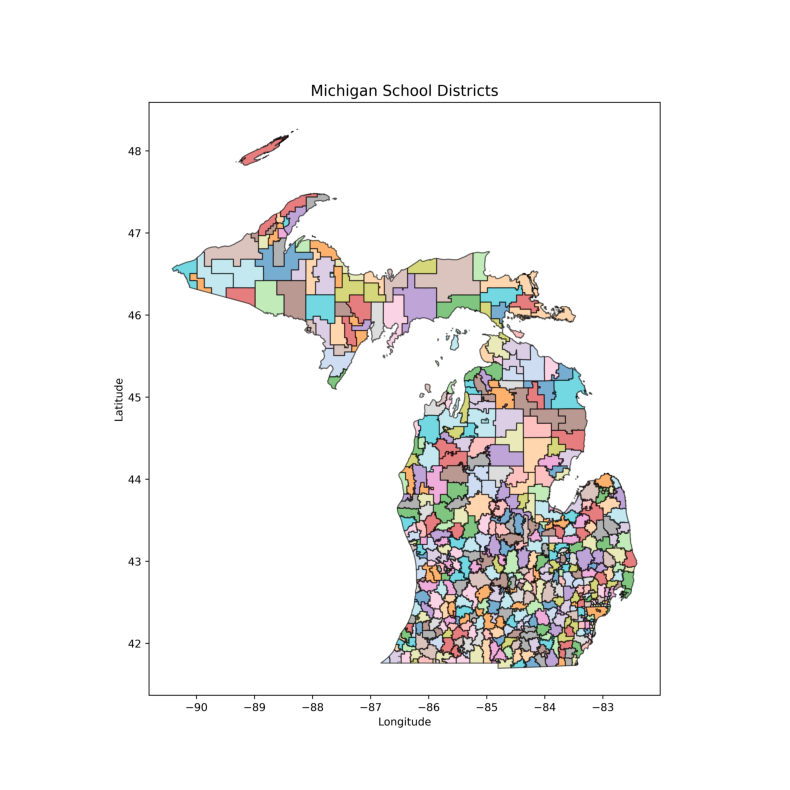

In [11]:
# District polygon correctness check
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/michigan_school_districts.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig, ax = plt.subplots(figsize=(10, 10))
    df_district_location.plot(ax=ax, edgecolor='black', cmap='tab20', alpha=0.6)
    
    ax.set_title("Michigan School Districts", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()
    fig.savefig(chart_name, dpi=500)


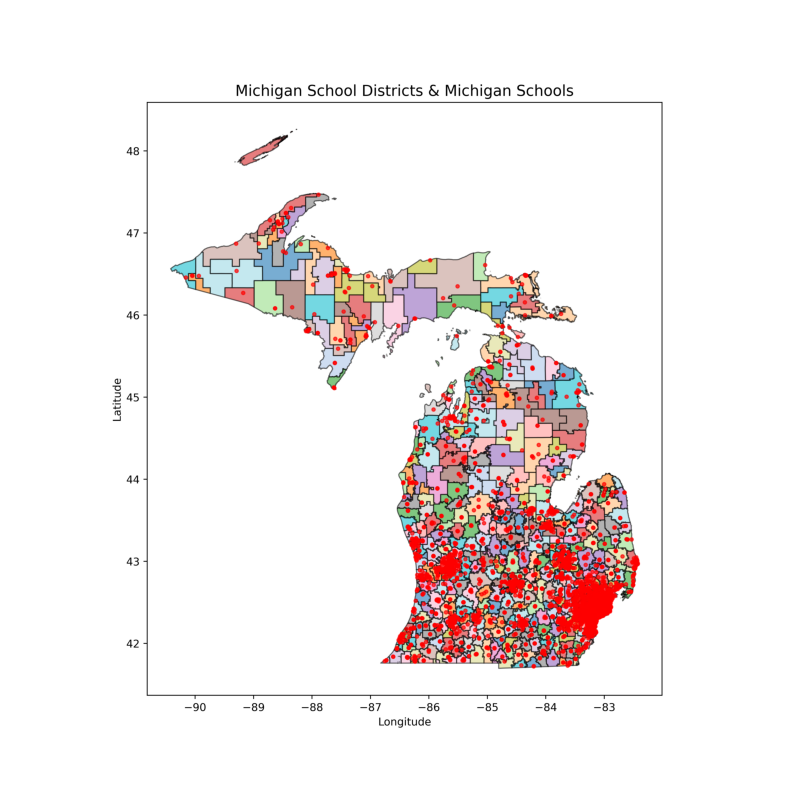

In [12]:
# District location correctness check
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/michigan_school_districts_and_schools.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig, ax = plt.subplots(figsize=(10, 10))
    df_district_location.plot(ax=ax, edgecolor="black", cmap="tab20", alpha=0.6)
    df_school_location.plot(
        ax=ax, marker="o", color="red", markersize=10, alpha=0.7, label="Schools"
    )
    ax.set_title("Michigan School Districts & Michigan Schools", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()
    fig.savefig(chart_name, dpi=500)


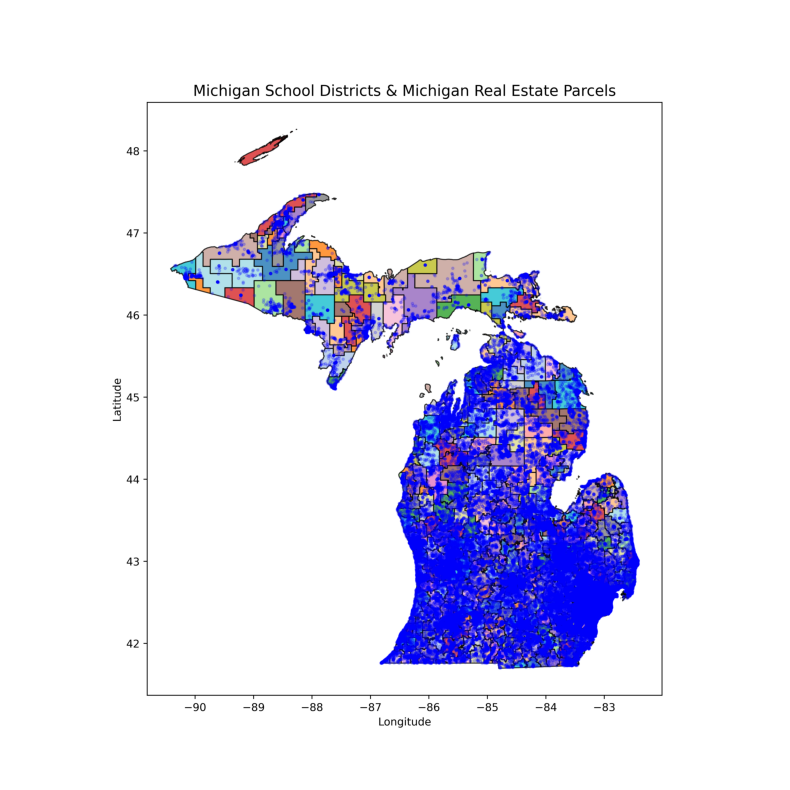

In [13]:
# Parcel location correctness check
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/michigan_school_districts_and_parcels.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig, ax = plt.subplots(figsize=(10, 10))
    df_district_location.plot(ax=ax, edgecolor="black", cmap="tab20", alpha=0.8)
    df_parcel.sample(n = 100000, random_state = random_state).plot(
        ax=ax, marker="o", color="blue", markersize=5, alpha=0.2, label="Schools"
    )
    
    ax.set_title("Michigan School Districts & Michigan Real Estate Parcels", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    plt.show()
    fig.savefig(chart_name, dpi=500)


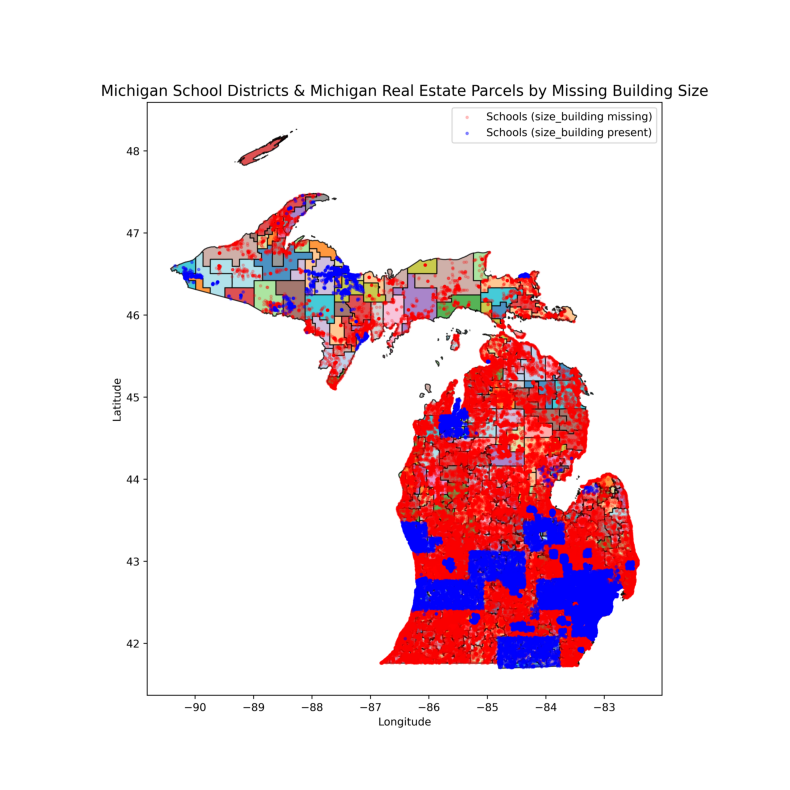

In [14]:
# Living/Building missingness check
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/df_parcel_missing_building_size.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig, ax = plt.subplots(figsize=(10, 10))
    df_district_location.plot(ax=ax, edgecolor="black", cmap="tab20", alpha=0.8)
    df_parcel_joined[df_parcel_joined['size_building'].isna()].sample(n=100000, random_state=random_state).plot(ax=ax, marker="o", color="red", markersize=5, alpha=0.2, label="Schools (size_building missing)")
    df_parcel_joined[df_parcel_joined['size_building'].notna()].sample(n=100000, random_state=random_state).plot(ax=ax, marker="o", color="blue", markersize=5, alpha=0.4, label="Schools (size_building present)")
    ax.set_title("Michigan School Districts & Michigan Real Estate Parcels by Missing Building Size", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.show()
    fig.savefig(chart_name, dpi=500)

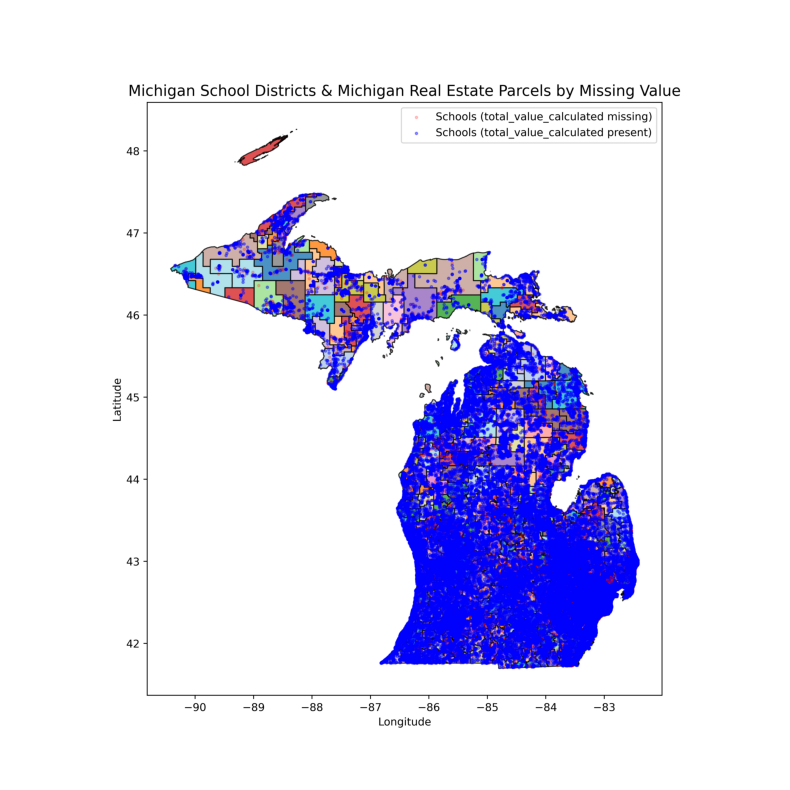

In [15]:
# Parcel valuation missingness check/distribution
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/df_parcel_missing_value.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig, ax = plt.subplots(figsize=(10, 10))
    df_district_location.plot(ax=ax, edgecolor="black", cmap="tab20", alpha=0.8)
    df_parcel_joined[df_parcel_joined['total_value_calculated'].notna()].sample(n=100000, random_state=random_state).plot(ax=ax, marker="o", color="blue", markersize=5, alpha=0.1, label="Schools (total_value_calculated present)")
    df_parcel_joined[df_parcel_joined['total_value_calculated'].isna()].sample(n=100000, random_state=random_state).plot(ax=ax, marker="o", color="red", markersize=5, alpha=1, label="Schools (total_value_calculated missing)")
    ax.set_title("Michigan School Districts & Michigan Real Estate Parcels by Missing Value", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.show()
    fig.savefig(chart_name, dpi=500)

### 3a) Missing values & Imputation

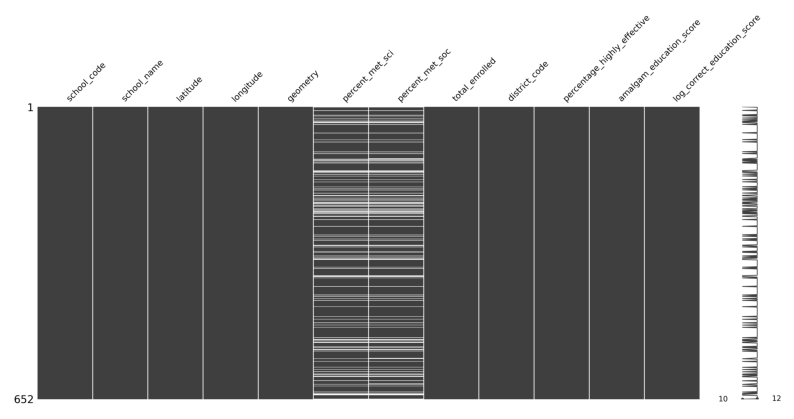

In [16]:
# df_school_joined missingness check/distribution
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/df_school_missing_data_matrix.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig = msno.matrix(df_school_joined)
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()


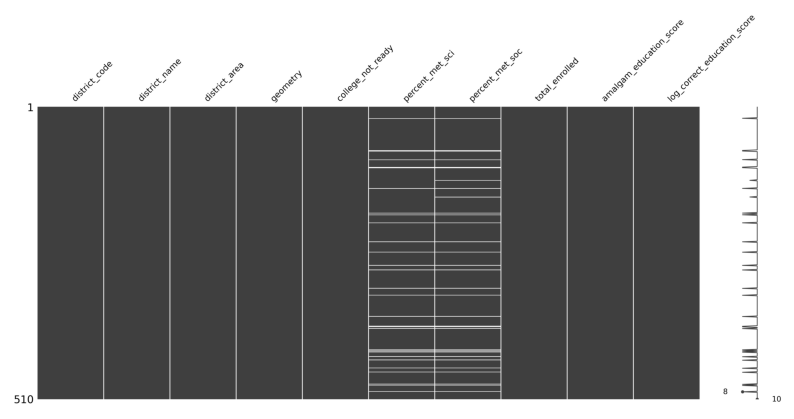

In [17]:
# df_district_joined missingness check/distribution
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/df_district_missing_data_matrix.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig = msno.matrix(df_district_joined)
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()

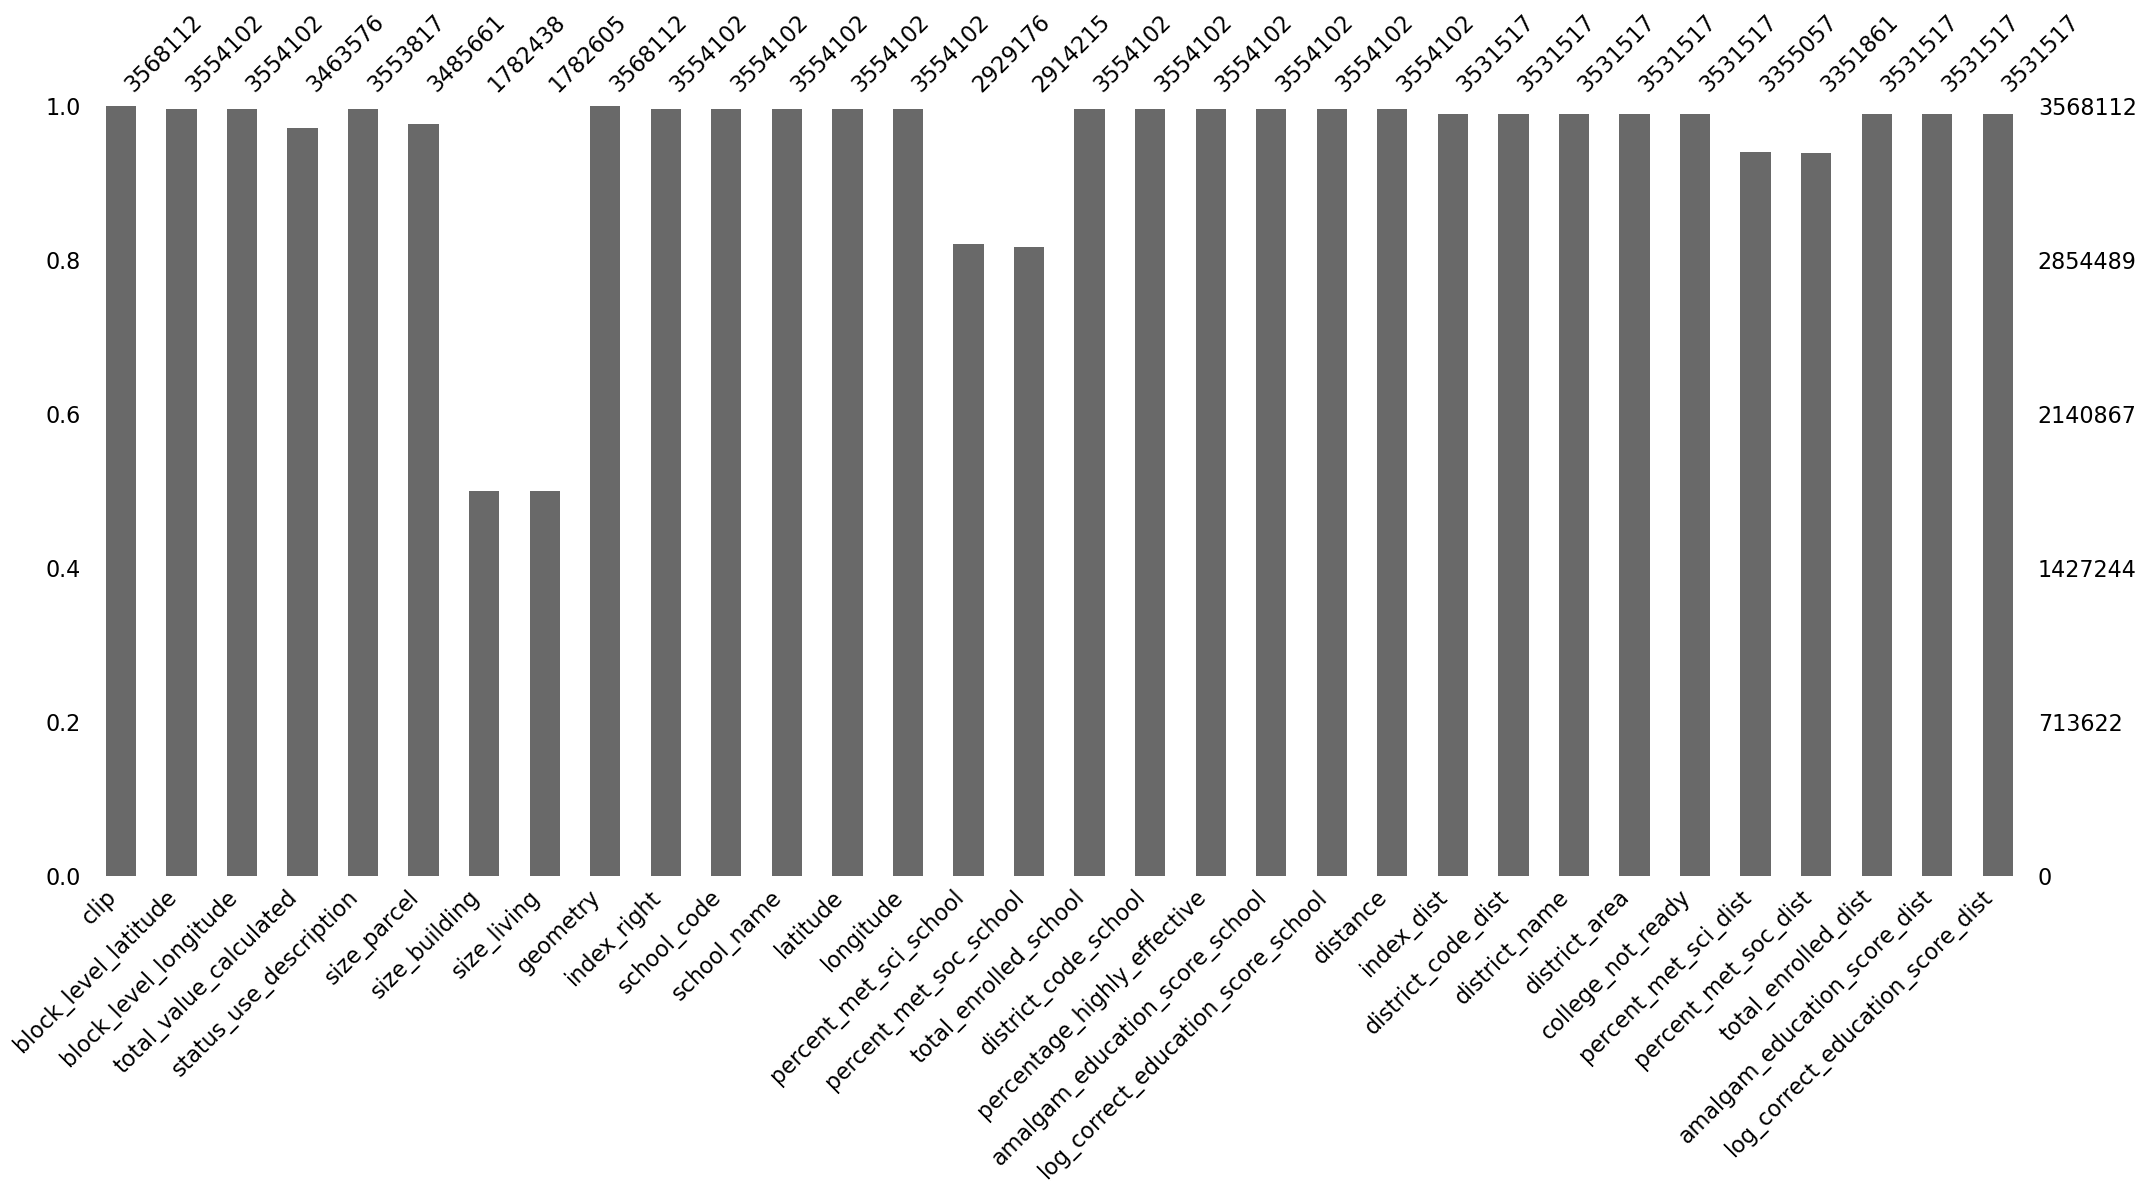

In [18]:
# df_parcel_joined missingness check
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/df_parcel_joined_missing_data_bars.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig = msno.bar(df_parcel_joined) 
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()

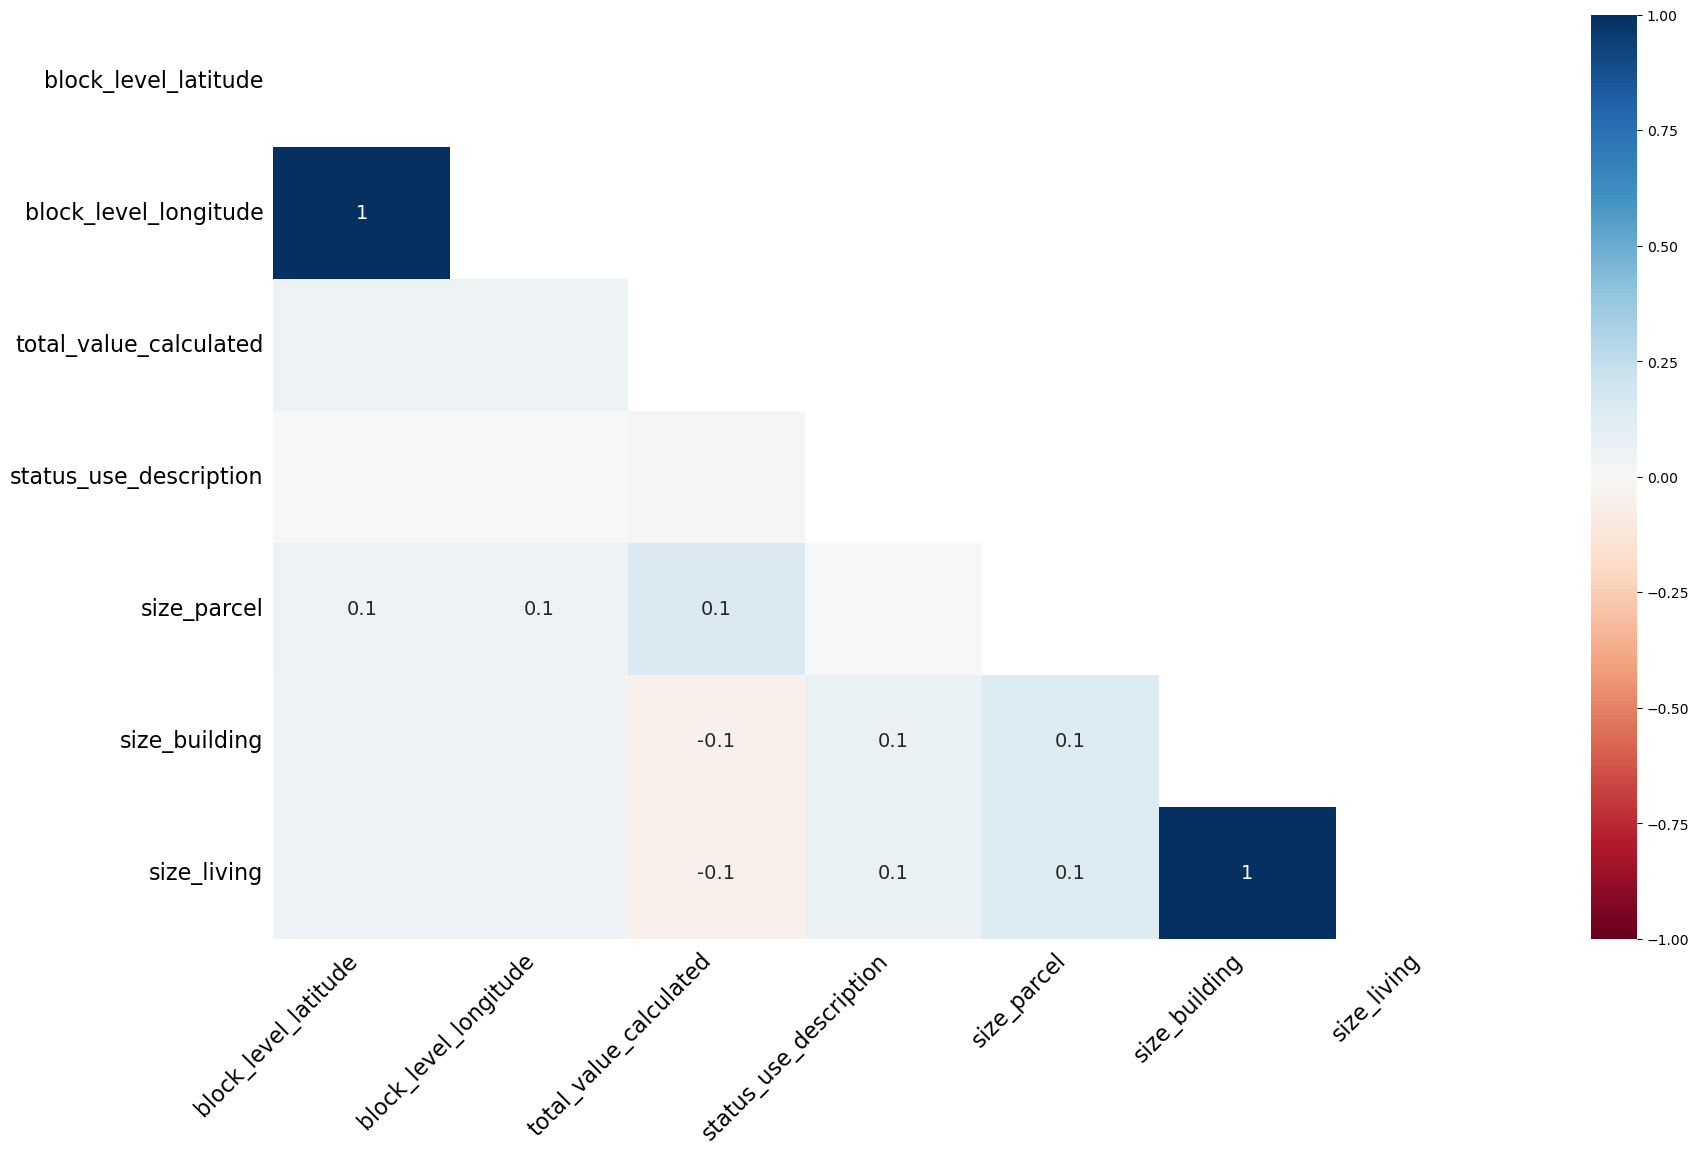

In [19]:
# Condotional missingness for df_parcel
# Implements caching, saves/reads plot from png file

#size_building and size_living are missing together

chart_name = "resources/charts/df_parcel_missing_data_heatmap.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    fig = msno.heatmap(df_parcel) 
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()

### 3b) Variable distributions

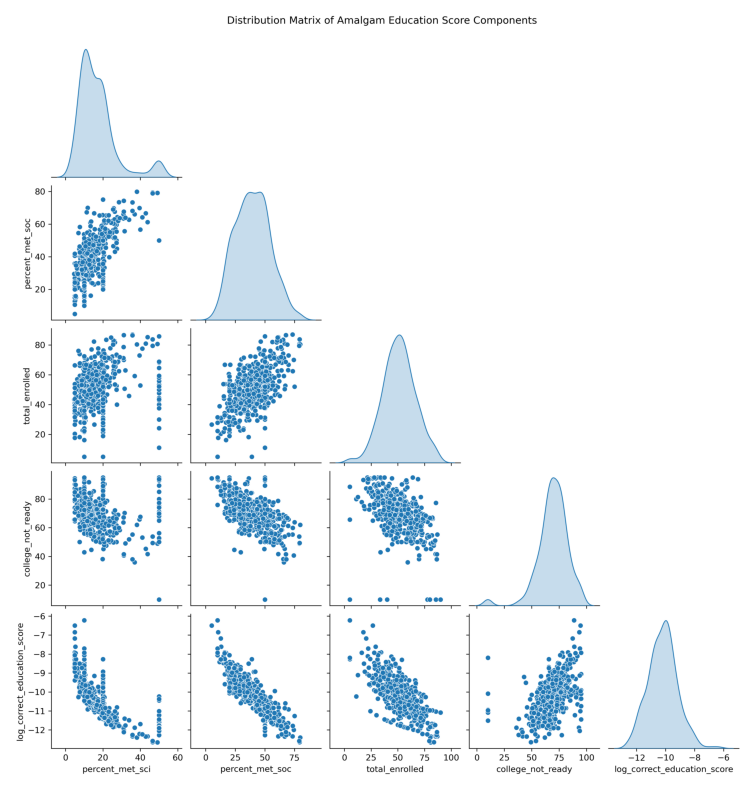

In [20]:
# District education score pair plot
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/df_district_pairplot.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    columns_to_plot = ['percent_met_sci', 'percent_met_soc', 'total_enrolled', 'college_not_ready','log_correct_education_score']
    sns.pairplot(df_district_joined[columns_to_plot], diag_kind='kde', corner=True)
    plt.suptitle("Distribution Matrix of Amalgam District Education Score Components", y=1.02)
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()

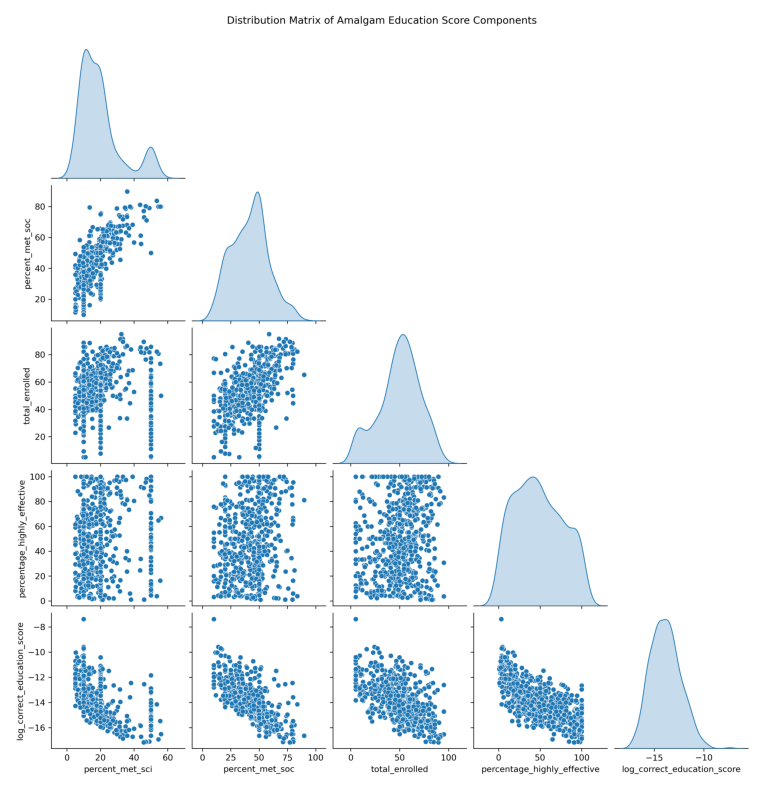

In [21]:
# School education score pair plot
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/df_school_pairplot.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    columns_to_plot = ['percent_met_sci', 'percent_met_soc', 'total_enrolled', 'percentage_highly_effective','log_correct_education_score']
    sns.pairplot(df_school_joined[columns_to_plot], diag_kind='kde', corner=True)
    plt.suptitle("Distribution Matrix of Amalgam School Education Score Components", y=1.02)
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()

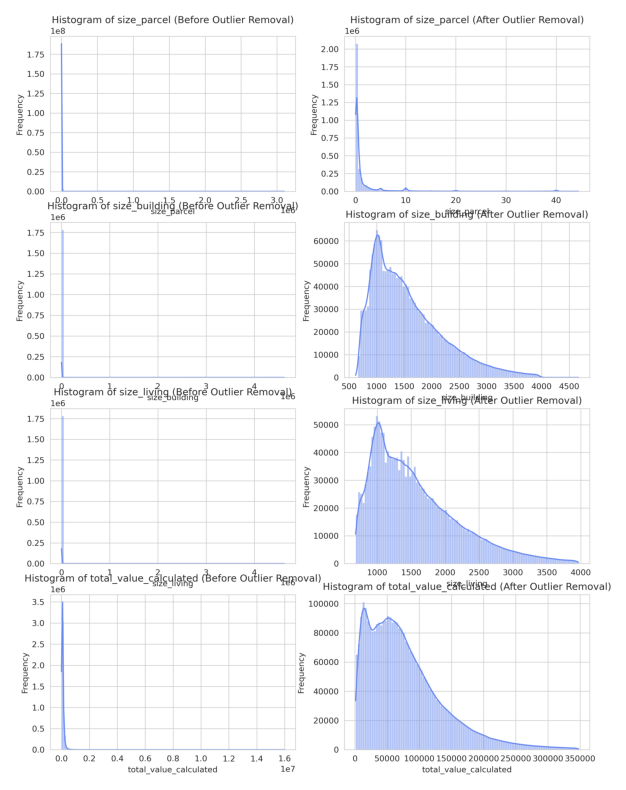

In [22]:
# CoreLogic attribute distributions before and after outlier removal
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/df_parcel_histogram.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    variables = ["size_parcel", "size_building", "size_living", "total_value_calculated"]
    fig, axes = plt.subplots(len(variables), 2, figsize=(12, 4 * len(variables)))
    
    for i, var in enumerate(variables):
        sns.histplot(df_parcel[var], bins=100, kde=True, ax=axes[i, 0])
        axes[i, 0].set_xlabel(var)
        axes[i, 0].set_ylabel("Frequency")
        axes[i, 0].set_title(f"Histogram of {var} (Before Outlier Removal)")
        
        sns.histplot(remove_outliers(df_parcel, variables)[var], bins=100, kde=True, ax=axes[i, 1])
        axes[i, 1].set_xlabel(var)
        axes[i, 1].set_ylabel("Frequency")
        axes[i, 1].set_title(f"Histogram of {var} (After Outlier Removal)")

    plt.subplots_adjust(hspace=0.4)
    plt.tight_layout()
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()


## 4) Analysis

### 4a) Additional Data Wrangling - Analysis

In [10]:
# Outlier removal
# Outliers are removed for columns in variable list
# Removal is done independently for each columns and ignore null values
variables = ["size_parcel", "size_building", "size_living", "total_value_calculated"]
df_parcel_joined = remove_outliers(df_parcel_joined, variables, left = 0.05, right = 0.95)

# Obtain valuation per acre of total parcel size
df_parcel_joined['total_value_parcel_unit'] = df_parcel_joined["total_value_calculated"]/df_parcel_joined["size_parcel"]

# Drop Null values for key attributes
df_parcel_joined = df_parcel_joined.dropna(subset = ["total_value_calculated",'block_level_longitude', 'block_level_latitude',"size_parcel"])

# District identifer is encoded for regression purposes
# Mean encoding approach is used, district_encoded attribute contains avarage valuation for each district 
mean_prices = df_parcel_joined.groupby('district_name')['total_value_parcel_unit'].mean()
df_parcel_joined['district_encoded'] = df_parcel_joined['district_name'].map(mean_prices)

### 4b) Data Sampling

In [10]:
# Small random sample for correlation visualization
# This results in 2K rows
df_parcel_clean_small = df_parcel_joined.dropna(subset = ["total_value_calculated"]).sample(n = 2000, random_state = random_state)
df_parcel_clean_medium = df_parcel_joined.dropna(subset = ["total_value_calculated"]).sample(n = 50000, random_state = random_state)

# large random sample for regression 
# 20/80 train/test split to be used, given the large size of the data
# This results in 1M rows, 200K/800K train/test
df_parcel_clean_large = df_parcel_joined.dropna(subset = ["total_value_calculated", "size_parcel", 'distance', 
                                                          'log_correct_education_score_school', 'log_correct_education_score_dist', 
                                                          'block_level_longitude', 'block_level_latitude']).sample(n = 1000000, random_state = random_state)

# Stratified sampling is used to obtain 100 parcels per district 
# This results in ~60K rows
df_parcel_clean_stratified = df_parcel_joined.dropna(subset=["total_value_calculated"]).groupby("district_code_dist", group_keys=False).apply(lambda x: x.sample(n=min(len(x), 100), random_state=random_state))

# Stratified sampling is used to obtain 1 parcel per 0.09 degrees or ~10 km 
# This results in ~ 3K rows
grid_size = 0.09 
df_parcel_joined["lat_bin"] = np.floor(df_parcel_joined["block_level_latitude"] / grid_size).astype(int)
df_parcel_joined["lon_bin"] = np.floor(df_parcel_joined["block_level_longitude"] / grid_size).astype(int)
df_parcel_clean_grid_sample = df_parcel_joined.dropna(subset=["total_value_calculated", 'log_correct_education_score_school']).groupby(["lat_bin", "lon_bin"], group_keys=False).sample(n=1, random_state=random_state)
df_parcel_clean_grid_sample = df_parcel_clean_grid_sample.drop(columns=["lat_bin", "lon_bin"])
df_parcel_joined = df_parcel_joined.drop(columns=["lat_bin", "lon_bin"])


### 4c) Variable Correlation

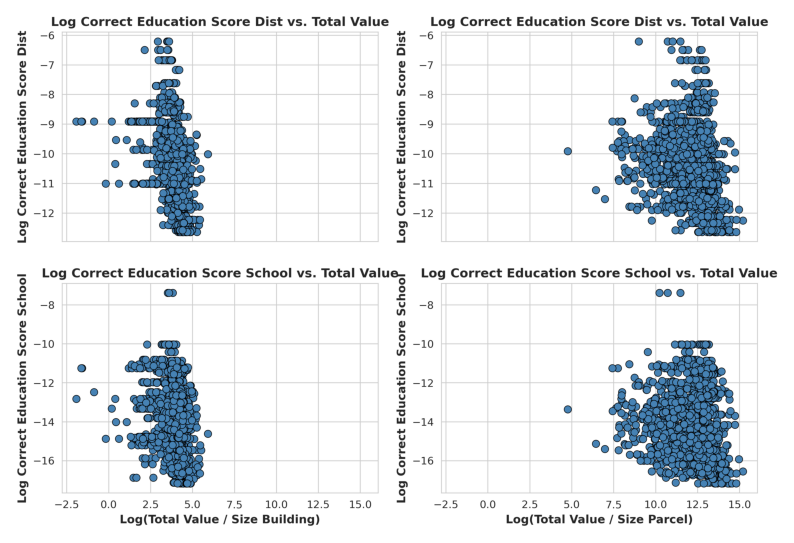

In [25]:
# Correlation chart
# Parcel value / building or parcel size on X axis 
# District / School level logged education score on Y axis
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/df_parcel_correlation.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    education_cols = ["log_correct_education_score_dist", "log_correct_education_score_school"]
    size_factors = ["size_building", "size_parcel"]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=False)
    
    for i, edu_col in enumerate(education_cols):
        for j, size_col in enumerate(size_factors):
            ax = axes[i, j]
            sns.scatterplot(
                y=df_parcel_clean_small[edu_col], x=np.log(df_parcel_clean_small["total_value_calculated"] / df_parcel_clean_small[size_col]), 
                color="steelblue",alpha= 1,edgecolor="black", s=20, ax=ax)
            ax.set_xlabel(f"Log(Total Value / {size_col.replace('_', ' ').title()})", fontsize=11, fontweight='bold')
            ax.set_ylabel(edu_col.replace("_", " ").title(), fontsize=11, fontweight='bold')
            ax.set_title(f"{edu_col.replace('_', ' ').title()} vs. Total Value", fontsize=12, fontweight='bold')
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

### 4d) Regression Model

In [14]:
# Random forest regression
# Two regression models are fitted and saved as pickle files
# First model contains district_encoded, the second does not (refer to section 4b)

# In case retrain_models == False, the models are read from the pickle file in required_files list
required_files = ["resources/models/rf_with_district.pkl","resources/models/rf_without_district.pkl"]

X = df_parcel_clean_large[['distance', 'log_correct_education_score_school', 'log_correct_education_score_dist', 'block_level_longitude', 'block_level_latitude', 'district_encoded']]
y = np.log(df_parcel_clean_large["total_value_calculated"] / df_parcel_clean_large["size_parcel"])

# Given large size of the data 20/80 train/test split is used
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=random_state) 

if retrain_models == False and all(os.path.exists(file) for file in required_files):
    with open("resources/models/rf_with_district.pkl", "rb") as f:
        rf_with_district = pickle.load(f)
    
    with open("resources/models/rf_without_district.pkl", "rb") as f:
        rf_without_district = pickle.load(f)

else:
    # First model with district_encoded
    rf_with_district = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=random_state)
    rf_with_district.fit(X_train, y_train)

    # Second model with district_encoded
    rf_without_district = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=random_state)
    rf_without_district.fit(X_train.drop(columns=['district_encoded']), y_train)
    
    with open("resources/models/rf_with_district.pkl", "wb") as f:
        pickle.dump(rf_with_district, f)
    
    with open("resources/models/rf_without_district.pkl", "wb") as f:
        pickle.dump(rf_without_district, f)

y_pred_with_district = rf_with_district.predict(X_test)
y_pred_without_district = rf_without_district.predict(X_test.drop(columns=['district_encoded']))

r2_with = r2_score(y_test, y_pred_with_district)
mae_with = mean_absolute_error(y_test, y_pred_with_district)
rmse_with = np.sqrt(mean_squared_error(y_test, y_pred_with_district))

r2_without = r2_score(y_test, y_pred_without_district)
mae_without = mean_absolute_error(y_test, y_pred_without_district)
rmse_without = np.sqrt(mean_squared_error(y_test, y_pred_without_district))

print(f"With District - R²: {r2_with:.4f}, MAE: {mae_with:.4f}, RMSE: {rmse_with:.4f}")
print(f"Without District - R²: {r2_without:.4f}, MAE: {mae_without:.4f}, RMSE: {rmse_without:.4f}")

# Each model results in following performance
# With District - R²: 0.6730, MAE: 0.6052, RMSE: 0.8921
# Without District - R²: 0.6784, MAE: 0.5940, RMSE: 0.8847




With District - R²: 0.5319, MAE: 0.6529, RMSE: 0.9021
Without District - R²: 0.6704, MAE: 0.5127, RMSE: 0.7570


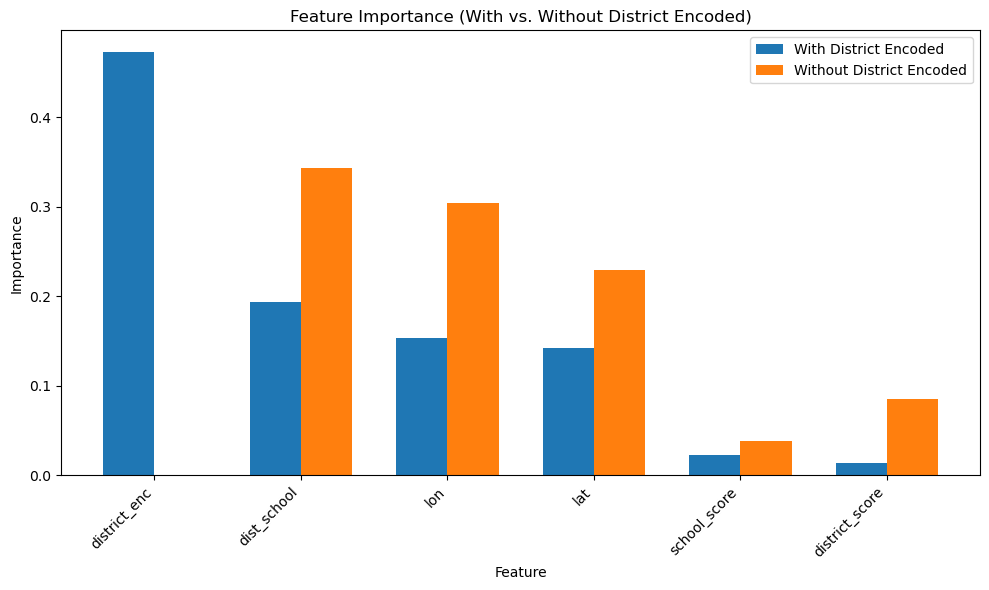

In [18]:
# Feature importance chart
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/feature_importance_plot.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    importances_with = rf_with_district.feature_importances_
    importances_without = rf_without_district.feature_importances_
    
    feature_names = ["dist_school", "school_score", "district_score", "lat", "lon"]
    feature_names_with_district = feature_names + ["district_enc"]

    sorted_indices = np.argsort(importances_with)[::-1]
    
    sorted_feature_names = np.array(feature_names_with_district)[sorted_indices]
    sorted_importances_with = importances_with[sorted_indices]

    importances_without_dict = dict(zip(feature_names, importances_without))
    sorted_importances_without = [importances_without_dict.get(f, 0) for f in sorted_feature_names]
    
    x = np.arange(len(sorted_feature_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, sorted_importances_with, width, label="With District Encoded")
    ax.bar(x + width/2, sorted_importances_without, width, label="Without District Encoded")
    
    ax.set_xticks(x)
    ax.set_xticklabels(sorted_feature_names, rotation=45, ha='right')
    ax.set_xlabel("Feature")
    ax.set_ylabel("Importance")
    ax.set_title("Feature Importance (With vs. Without District Encoded)")
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()

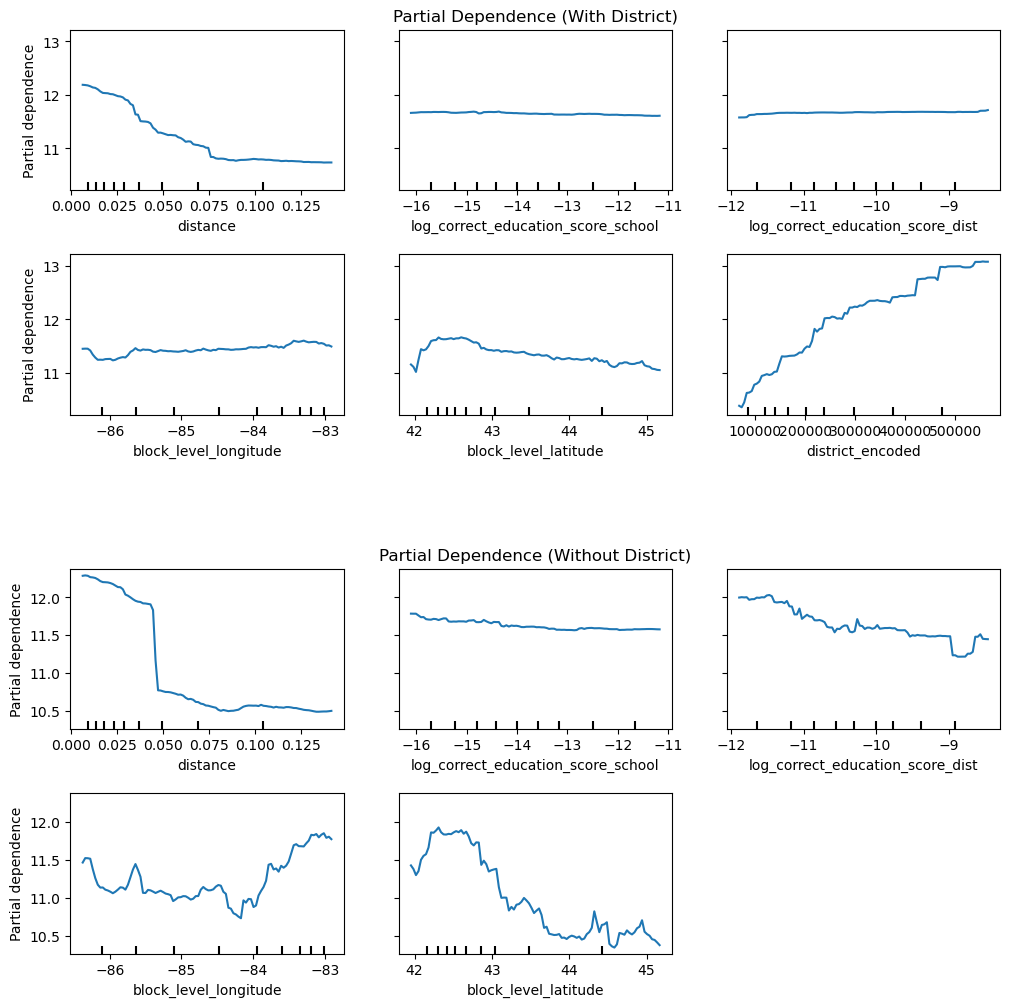

In [40]:
# Feature importance chart
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/pdp_plot.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:

    feature_names = ["distance", "log_correct_education_score_school", "log_correct_education_score_dist", "block_level_longitude", "block_level_latitude"]
    feature_names_with_district = feature_names + ["district_encoded"]

    # Obtaining smaller sample for pdp chart
    X_sample = X.sample(n=5000, random_state=random_state)
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    PartialDependenceDisplay.from_estimator(rf_with_district, X_sample, features=feature_names_with_district, kind="average", ax=axes[0])
    axes[0].set_title("Partial Dependence (With District)")
    
    PartialDependenceDisplay.from_estimator(rf_without_district, X_sample[feature_names], features=feature_names, kind="average", ax=axes[1])
    axes[1].set_title("Partial Dependence (Without District)")
    
    plt.subplots_adjust(hspace=0.4)
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()

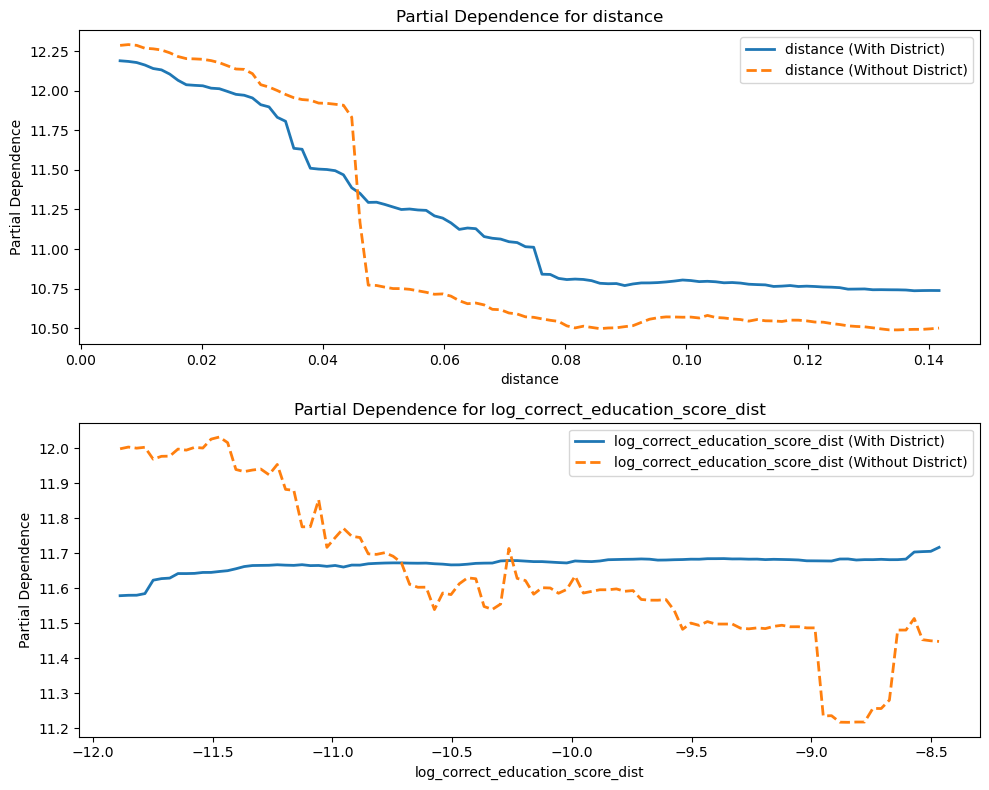

In [39]:

# Feature importance chart with limited features and overlayed curves
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/pdp_plot_v2.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    feature_names = ["distance", "log_correct_education_score_dist"]
    without_names = ["distance", "log_correct_education_score_school", "log_correct_education_score_dist", "block_level_longitude", "block_level_latitude"]
    
    # Obtaining smaller sample for PDP chart
    X_sample = X.sample(n=5000, random_state=random_state)
    
    fig, axes = plt.subplots(len(feature_names), 1, figsize=(10, 8), sharex=False)
    
    for i, feature in enumerate(feature_names):
        pdp_with = partial_dependence(rf_with_district, X_sample, features=[feature])
        x_with, y_with = pdp_with['values'][0], pdp_with["average"][0]
    
        pdp_without = partial_dependence(rf_without_district, X_sample[without_names], features=[feature])
        x_without, y_without = pdp_without['values'][0], pdp_without["average"][0]
    
        axes[i].plot(x_with, y_with, label=f"{feature} (With District)", linestyle='-', linewidth=2)
        axes[i].plot(x_without, y_without, label=f"{feature} (Without District)", linestyle='--', linewidth=2)
    
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Partial Dependence")
        axes[i].legend()
        axes[i].set_title(f"Partial Dependence for {feature}")
    
    plt.tight_layout()
    plt.savefig(chart_name, dpi=300, bbox_inches="tight")
    plt.show()


### 5) Visualization

### 5a) Additional Data Wrangling - Visualization

In [41]:
# Derive average valuation, parcel_size, distance to closest school for each district
df_parcel_district = df_parcel_joined.dropna(subset = ["total_value_calculated",'size_parcel']).groupby("district_code_dist")[["total_value_calculated", "size_parcel", "total_value_parcel_unit","distance"]].mean().reset_index()
df_parcel_district['log_total_value_calculated'] = np.log(df_parcel_district['total_value_calculated'] + 1)

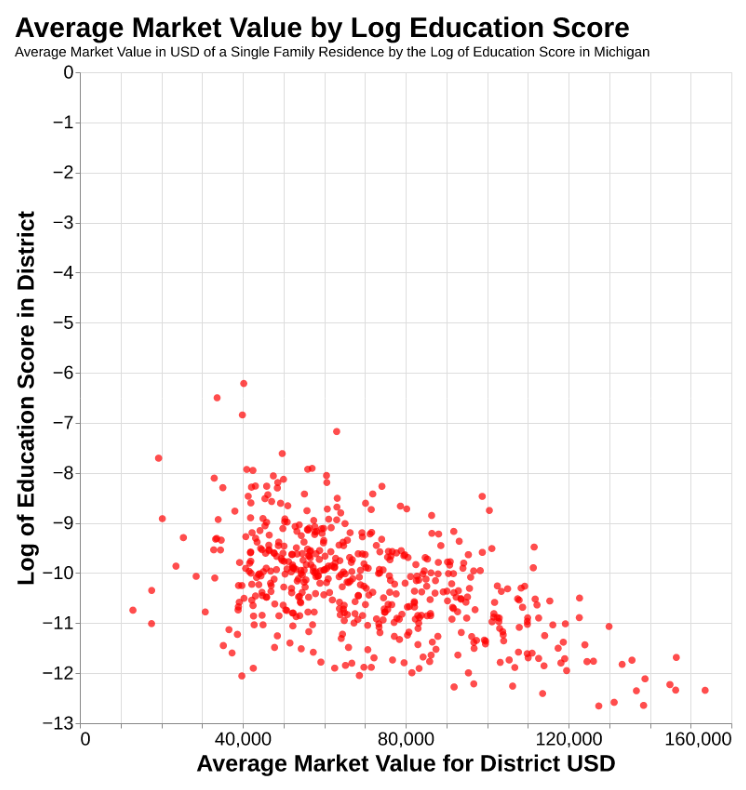

In [48]:
# Scatterplot log education schore-Y, average district market value-X
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/alt_scatter_avg_value_district_score.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    chart = alt.Chart(df_district_joined,title="Average Market Value by Log Education Score").mark_circle(size=60, color='red'
     ).encode(x=alt.X('total_value_calculated:Q', axis=alt.Axis(title='Average Market Value for District USD', titleFontSize=25, labelFontSize=20)), 
              y=alt.Y('log_correct_education_score:Q',axis=alt.Axis(title='Log of Education Score in District', titleFontSize=25, labelFontSize=20)), 
              tooltip='district_name'
    ).transform_lookup(
        lookup='district_code',
        from_=alt.LookupData(df_parcel_district, 'district_code_dist', ['total_value_calculated', 'size_parcel','total_value_parcel_unit', 'distance'])
    ).properties(
        width=700,
        height=700
    ).interactive().properties(
        title=alt.TitleParams(
        text="Average Market Value by Log Education Score", align='left',
        subtitle=['Average Market Value in USD of a Single Family Residence by the Log of Education Score in Michigan'],anchor='start',
        fontSize=30,
        font='sans-serif',
        color='black',
        subtitleFontSize=15, 
        subtitleColor='black', 
    ))
    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()

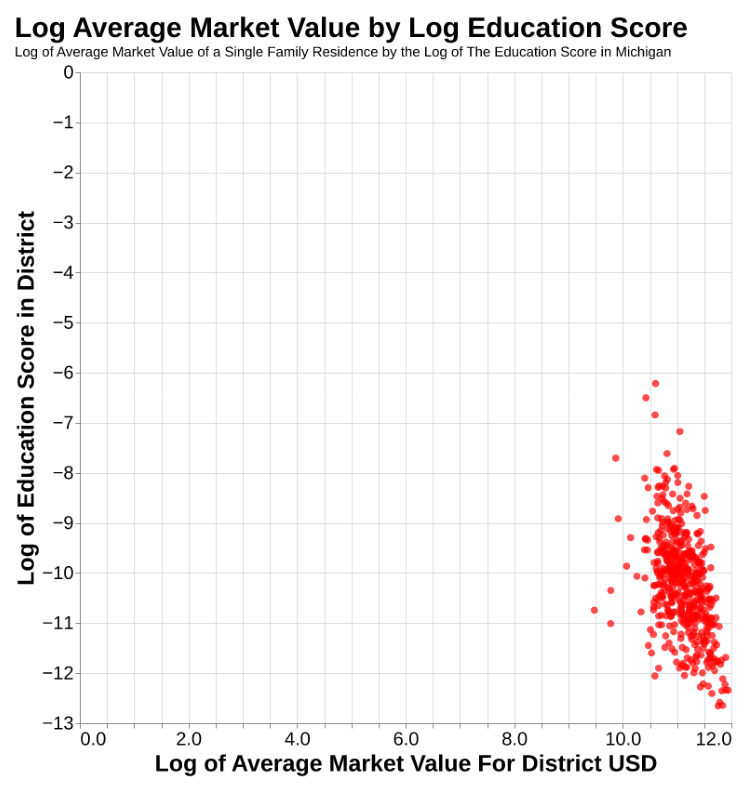

In [49]:
# Scatterplot log education score-Y, log average district market value-X
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/alt_scatter_log_avg_value_district_score.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    chart = alt.Chart(df_district_joined,title="Log Average Market Value by Log Education Score").mark_circle(size=60, color='red'
     ).encode(x=alt.X('log_total_value_calculated:Q', axis=alt.Axis(title='Log of Average Market Value For District USD', titleFontSize=25, labelFontSize=20)), 
              y=alt.Y('log_correct_education_score:Q',axis=alt.Axis(title='Log of Education Score in District', titleFontSize=25, labelFontSize=20)), 
              tooltip='district_name'
    ).transform_lookup(
        lookup='district_code',
        from_=alt.LookupData(df_parcel_district, 'district_code_dist', ['total_value_calculated', 'size_parcel','total_value_parcel_unit', 'distance'])
    ).transform_calculate(
        log_total_value_calculated="log(datum.total_value_calculated)"
    ).properties(
        width=700,
        height=700
    ).interactive().properties(
        title=alt.TitleParams(
        text="Log Average Market Value by Log Education Score", align='left',
        subtitle=['Log of Average Market Value of a Single Family Residence by the Log of The Education Score in Michigan'],anchor='start',
        fontSize=30,
        font='sans-serif',
        color='black',
        subtitleFontSize=15, 
        subtitleColor='black', 
    ))
    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()

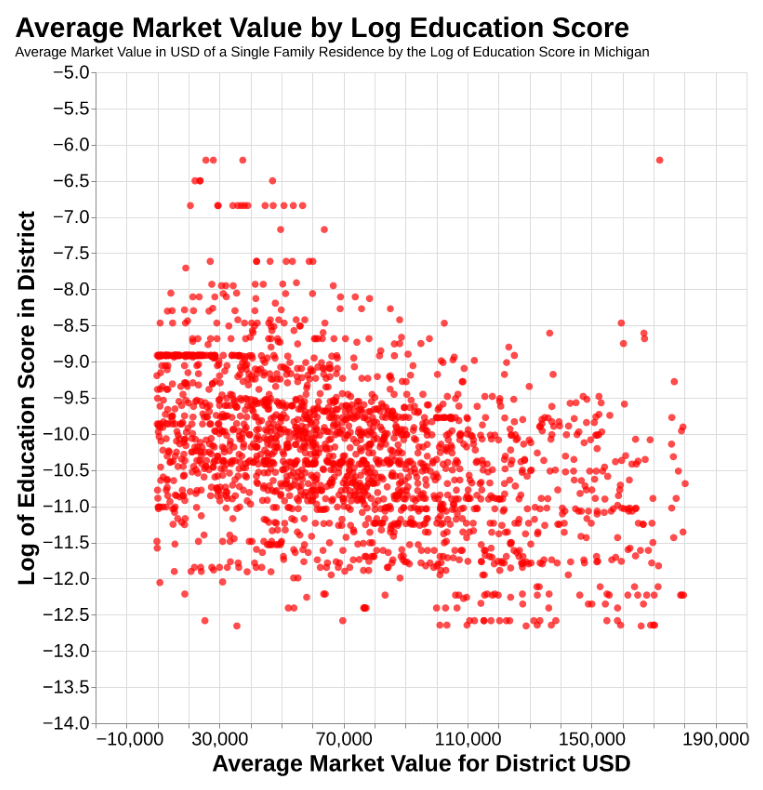

In [25]:
# Scatterplot Log education schore-Y, Market Value-X
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/alt_scatter_log_district_score_valuation.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    chart = alt.Chart(df_parcel_clean_small,title="Market Value by Log Education Score").mark_circle(size=60, color='red'
    ).encode(x=alt.X('total_value_calculated:Q', axis=alt.Axis(title='Market Value for District USD', titleFontSize=25, labelFontSize=20), scale=alt.Scale(domain=[-10000, 200000])), 
             y=alt.Y('log_correct_education_score_dist:Q',axis=alt.Axis(title='Log of Education Score in District', titleFontSize=25, labelFontSize=20), scale=alt.Scale(domain=[-14, -5])), 
             tooltip='district_name').properties(
        width=700,
        height=700
    ).interactive().properties(
        title=alt.TitleParams(
            text="Market Value by Log Education Score", align='left',
            subtitle=['Market Value in USD of a Single Family Residence by the Log of Education Score in Michigan'],anchor='start',
            fontSize=30,
            font='sans-serif',
            color='black',
            subtitleFontSize=15, 
            subtitleColor='black', 
        ))
    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()

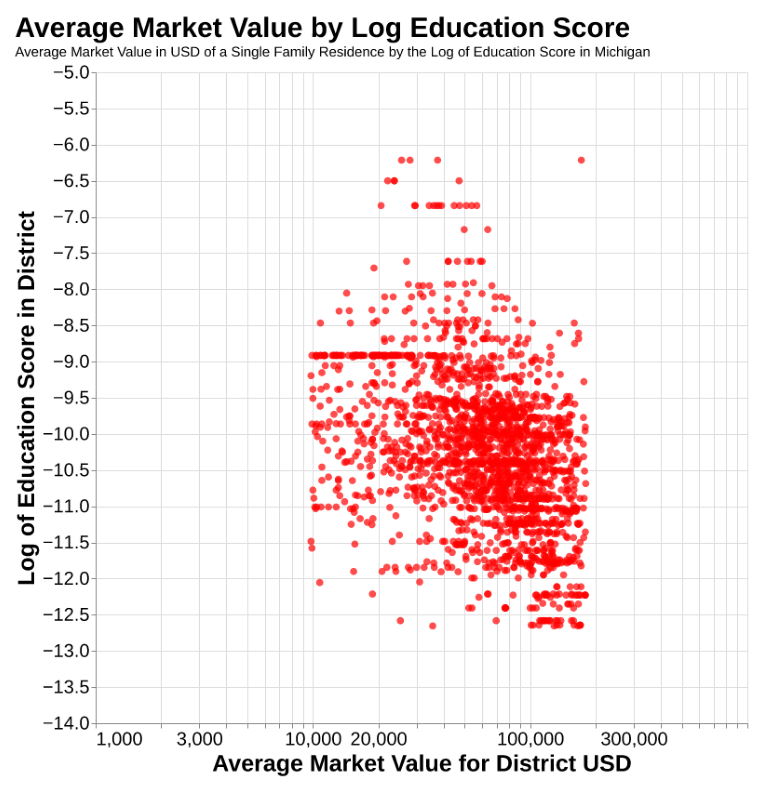

In [36]:
# Scatterplot Log education schore-Y, Log Market Value-X
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/alt_scatter_log_district_score_log_valuation.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    chart = alt.Chart(df_parcel_clean_small,title="Log Market Value by Log Education Score").mark_circle(size=60, color='red'
    ).encode(x=alt.X('total_value_calculated:Q', axis=alt.Axis(title='Log Market Value for District USD', titleFontSize=25, labelFontSize=20), scale=alt.Scale(type='log')), 
             y=alt.Y('log_correct_education_score_dist:Q',axis=alt.Axis(title='Log of Education Score in District', titleFontSize=25, labelFontSize=20), scale=alt.Scale(domain=[-14, -5])), 
             tooltip='district_name').properties(
        width=700,
        height=700
    ).interactive().properties(
        title=alt.TitleParams(
            text="Log Market Value by Log Education Score", align='left',
            subtitle=['Log Market Value of a Single Family Residence by the Log of Education Score in Michigan'],anchor='start',
            fontSize=30,
            font='sans-serif',
            color='black',
            subtitleFontSize=15, 
            subtitleColor='black', 
        ))
    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()

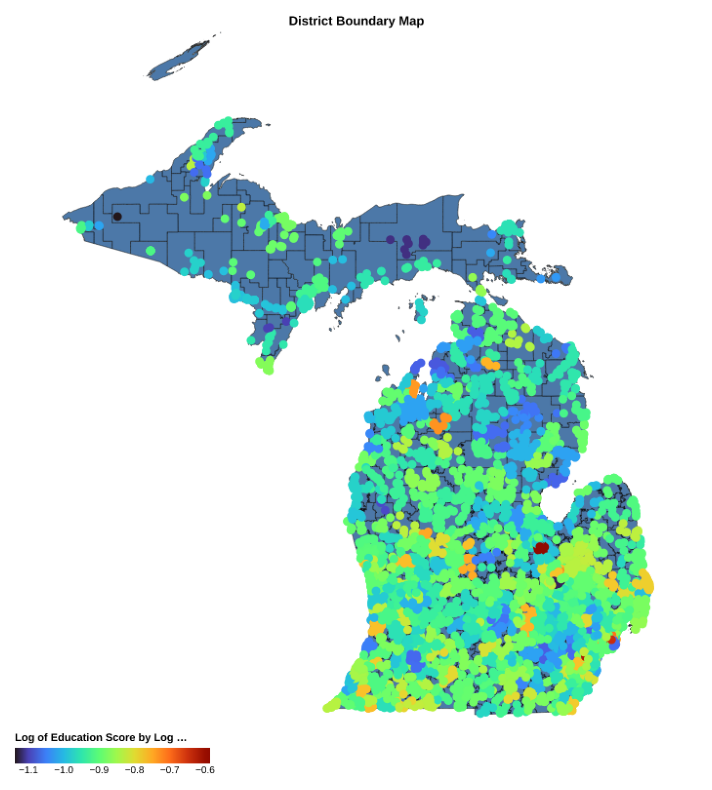

In [14]:
#### Used in Report #####




chart_name = "resources/charts/alt_map_scatter_parcel_average_valuation_district_score.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    grouped = df_parcel_joined.groupby('district_code_dist')['total_value_calculated'].mean()
    df_parcel_joined = pd.merge(df_parcel_joined, grouped, left_on='district_code_dist', right_index=True)
    df_parcel_joined['log_corrected_market_value'] = np.log(df_parcel_joined['total_value_calculated_y'])
    df_parcel_joined['log_corrected_education_score_by_log_c_market_value_score'] = (df_parcel_joined['log_correct_education_score_dist'] / df_parcel_joined['log_corrected_market_value'])
    source = df_parcel_joined.sample(n = 10000, random_state = random_state)
    df_disct = alt.Chart(df_district_location, title ="District Boundary Map").mark_geoshape(stroke='black', strokeWidth=0.5).encode().project(type='mercator').properties(width=700,height=700).interactive()
    
    
    map_log_edu_log_maket = alt.Chart(source, title ="Log Education Score by Log Average Market Value Score by School District").mark_geoshape(size=50).encode(
        color=alt.Color('log_corrected_education_score_by_log_c_market_value_score').scale(scheme="turbo").legend(orient="bottom", title="Log of Education Score by Log of Market Value Score", labelLimit = 400), tooltip='district_name'
    ).project(
        type='mercator').properties(
        width=700,
        height=700
    ).interactive().properties(
        title=alt.TitleParams(
            text="Log Education Score by Log Market Value Score by School District", align='left',
            subtitle=['Log of Education Score by Log of Market Value in USD Score by School District in Michigan'],anchor='start',
            fontSize=30,
            font='sans-serif',
            color='black',
            subtitleFontSize=15, 
            subtitleColor='black', 
        ))
    
    
    chart =  df_disct + map_log_edu_log_maket
    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()

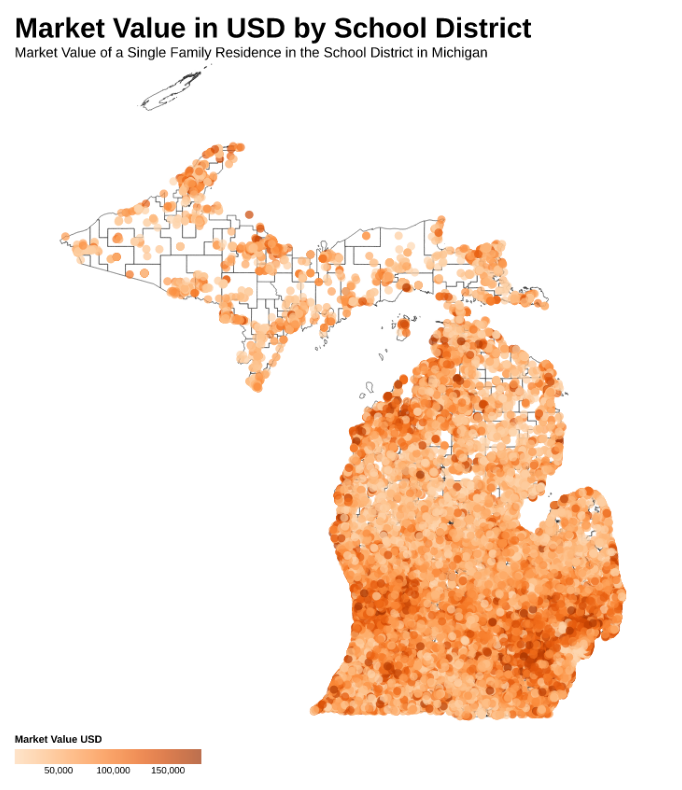

In [60]:
# Base plot - district boarders 
# Layer plot - color encoded parcel value
# The input data is obtained using random sampling
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/alt_map_parcel_valuation.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    chart_district = alt.Chart(df_district_joined, title ="District Boundary Map").mark_geoshape(
        stroke='black', strokeWidth=0.5, fill='white').encode().project(type='mercator').properties(
        width=700,height=700).interactive()
    
    chart_layer  = alt.Chart(df_parcel_clean_medium, title ="Market Value in USD by School District").mark_geoshape(size=15, opacity=0.7).encode(
        color=alt.Color('total_value_calculated').scale(scheme="oranges").legend(orient="bottom", title="Market Value USD", labelLimit = 400), tooltip='total_value_calculated' 
    ).project(
        type='mercator').properties(
        width=700,
        height=700
    ).interactive()
    chart = (chart_district + chart_layer).properties(
        title=alt.TitleParams(
            text="Market Value in USD by School District", align='left',
            subtitle=['Market Value of a Single Family Residence in the School District in Michigan'],anchor='start',
            fontSize=30,
            font='sans-serif',
            color='black',
            subtitleFontSize=15, 
            subtitleColor='black', 
        ))
    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()

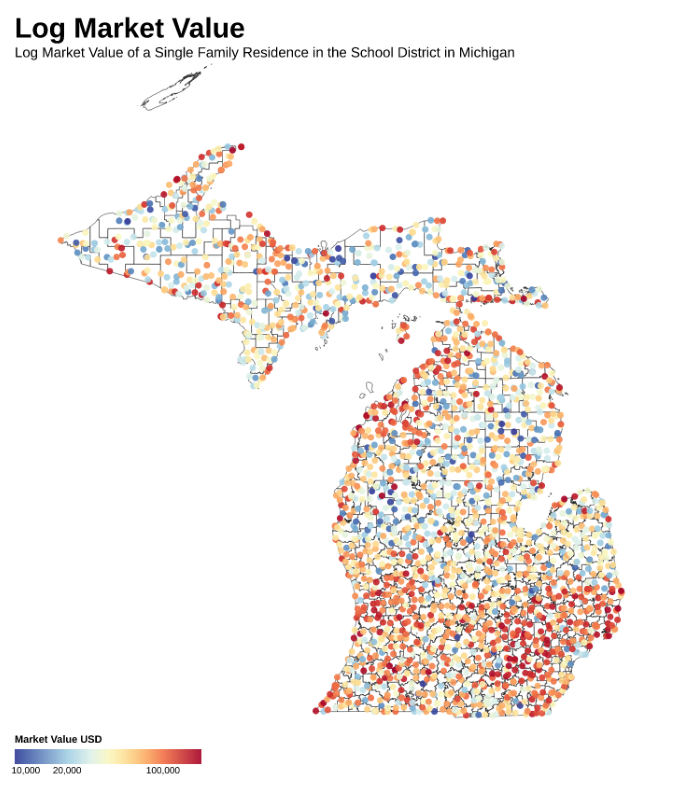

In [46]:
# Base plot - district boarders 
# Layer plot - color log encoded parcel value
# The input data is obtained using grid based stratifed sampling
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/alt_map_parcel_log_valuation.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    chart_district = alt.Chart(df_district_joined, title ="District Boundary Map").mark_geoshape(
        stroke='black', strokeWidth=0.5, fill='white').encode().project(type='mercator').properties(
        width=700,height=700).interactive()
    
    chart_layer  = alt.Chart(df_parcel_clean_grid_sample, title="Log Market Value").mark_circle(opacity=0.9, size=50).encode(
        longitude='block_level_longitude:Q',  # Extract longitude
        latitude='block_level_latitude:Q',  # Extract latitude
        color=alt.Color('total_value_calculated:Q').scale(scheme="redyellowblue", type='log', reverse=True).legend(
            orient="bottom", title="Market Value USD", labelLimit=400
        ), 
        tooltip='total_value_calculated' 
    ).project(
        type='mercator'
    ).properties(
        width=700,
        height=700
    ).interactive()
    chart = (chart_district + chart_layer).properties(
        title=alt.TitleParams(
            text="Log Market Value", align='left',
            subtitle=['Log Market Value of a Single Family Residence in the School District in Michigan'],anchor='start',
            fontSize=30,
            font='sans-serif',
            color='black',
            subtitleFontSize=15, 
            subtitleColor='black', 
        ))
    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()

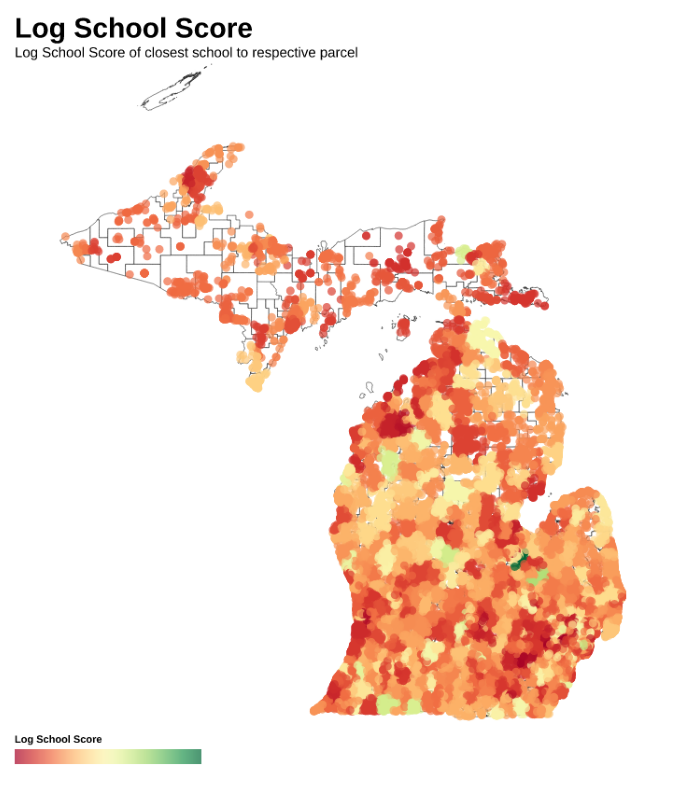

In [62]:
# Base plot - district boarders 
# Layer plot - color encoded log school education score
# The input data is obtained using random sampling
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/alt_map_parcel_log_school_score.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    chart_district = alt.Chart(df_district_joined, title ="District Boundary Map").mark_geoshape(stroke='black', strokeWidth=0.5, fill='white').encode().project(type='mercator').properties(width=700,height=700).interactive()
    
    chart_layer  = alt.Chart(df_parcel_clean_medium, title ="Log School Score of Closest School").mark_geoshape(size=15, opacity=0.7).encode(
        color=alt.Color('log_correct_education_score_school').scale(scheme="redyellowgreen", type='log').legend(orient="bottom", title="Log School Score", labelLimit = 400), tooltip='log_correct_education_score_school' 
    ).project(
        type='mercator').properties(
        width=700,
        height=700
    ).interactive()
    chart = (chart_district + chart_layer).properties(
        title=alt.TitleParams(
            text="Log School Score", align='left',
            subtitle=['Log School Score of closest school to respective parcel'],anchor='start',
            fontSize=30,
            font='sans-serif',
            color='black',
            subtitleFontSize=15, 
            subtitleColor='black', 
        ))
    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()

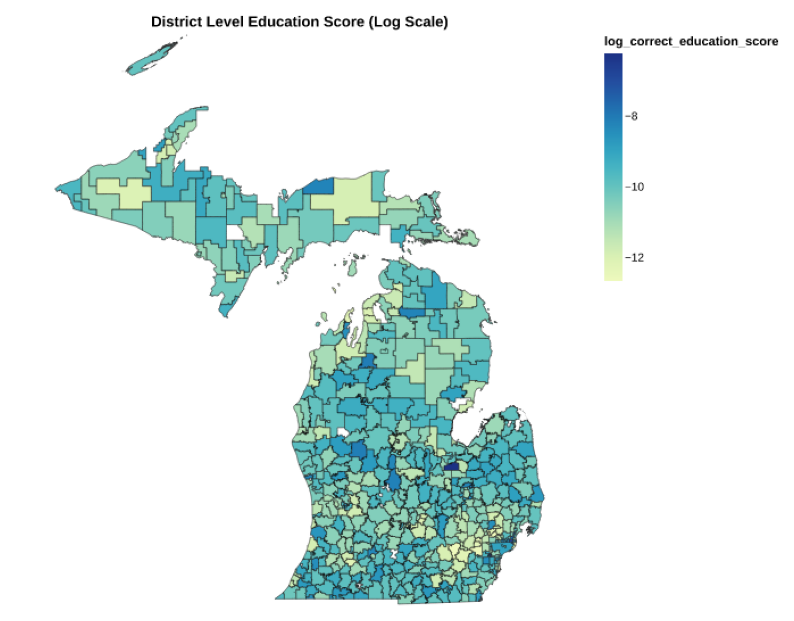

In [37]:
# Base plot - district boarders + color encoded district education score
# The input data is obtained by averaging education scores for entire dataset
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/alt_district_education_score.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    chart = alt.Chart(df_district_joined, title="District Level Education Score (Log Scale)").mark_geoshape(stroke='black', strokeWidth=0.5).encode(
        color='log_correct_education_score:Q'
    ).project(
    type='mercator').properties(
    width=500,
    height=500
    )
    
    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()

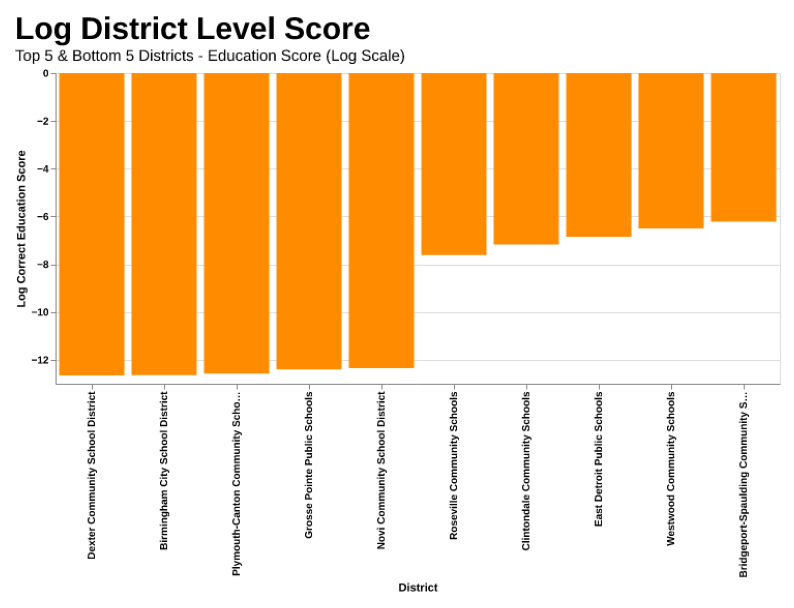

In [126]:
# Base plot - bar chart - district level education score
# The input data is obtained by averaging education scores for entire dataset
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/log_district_level_score.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    chart = alt.Chart(
            df_district_joined.sort_values('log_correct_education_score', ascending=False)
            .iloc[list(range(5)) + list(range(-5, 0))]
        ).mark_bar(color='darkorange').encode(
            x=alt.X('district_name:N', sort='y', title="District", axis=alt.Axis(labelFontWeight='bold')),
            y=alt.Y('log_correct_education_score:Q', title="Log Correct Education Score", axis=alt.Axis(labelFontWeight='bold'))
        ).properties(
            title=alt.TitleParams(
            text="Log District Level Score", align='left',
            subtitle=['Top 5 & Bottom 5 Districts - Education Score (Log Scale)'],anchor='start',
            fontSize=30,
            font='sans-serif',
            color='black',
            subtitleFontSize=15, 
            subtitleColor='black'
        ),
        width=700,
        height=300)
    
    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()

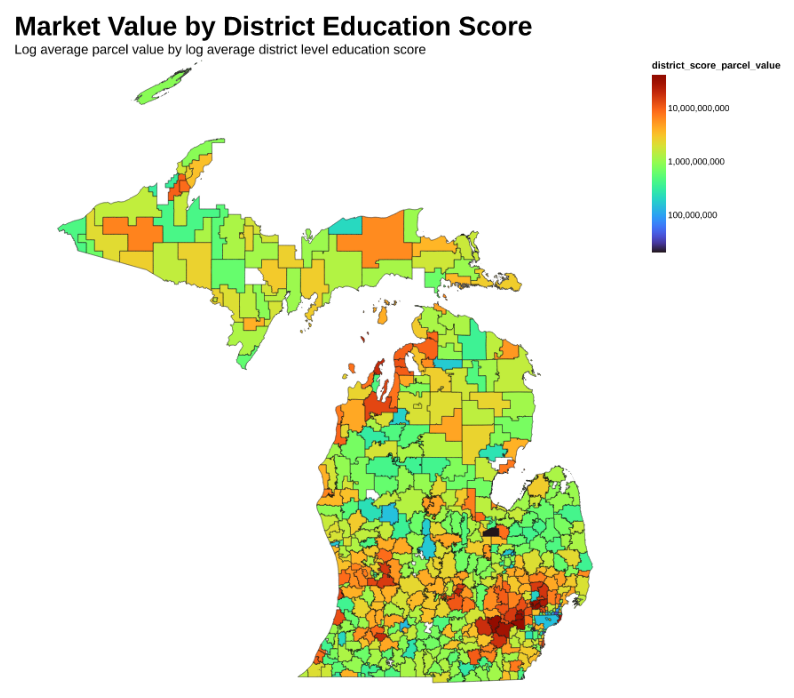

In [125]:
# Base plot - district boarders + color encoded district average parcel value / district education score + logged color scale
# The input data is obtained by averaging education scores for entire dataset
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/alt_district_score_per_parcel_value_logged_scale.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    chart = alt.Chart(df_district_joined, title="Parcel Total Valuation Per Acre (Log Scale)").mark_geoshape(stroke='black', strokeWidth=0.5).encode(
        color=alt.Color('district_score_parcel_value:Q').scale(scheme="turbo", type='log')
    ).transform_lookup(
        lookup='district_code',
        from_=alt.LookupData(df_parcel_district, 'district_code_dist', ['total_value_calculated', 'size_parcel','total_value_parcel_unit', 'distance'])
    ).transform_calculate(
        district_score_parcel_value="datum.total_value_calculated / datum.amalgam_education_score"
    ).project(
    type='mercator'
    ).properties(
        width=700,
        height=700
    ).properties(
            title=alt.TitleParams(
            text="Market Value by District Education Score", align='left',
            subtitle=['Log average parcel value by log average district level education score'],anchor='start',
            fontSize=30,
            font='sans-serif',
            color='black',
            subtitleFontSize=15, 
            subtitleColor='black', 
    ))

    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()

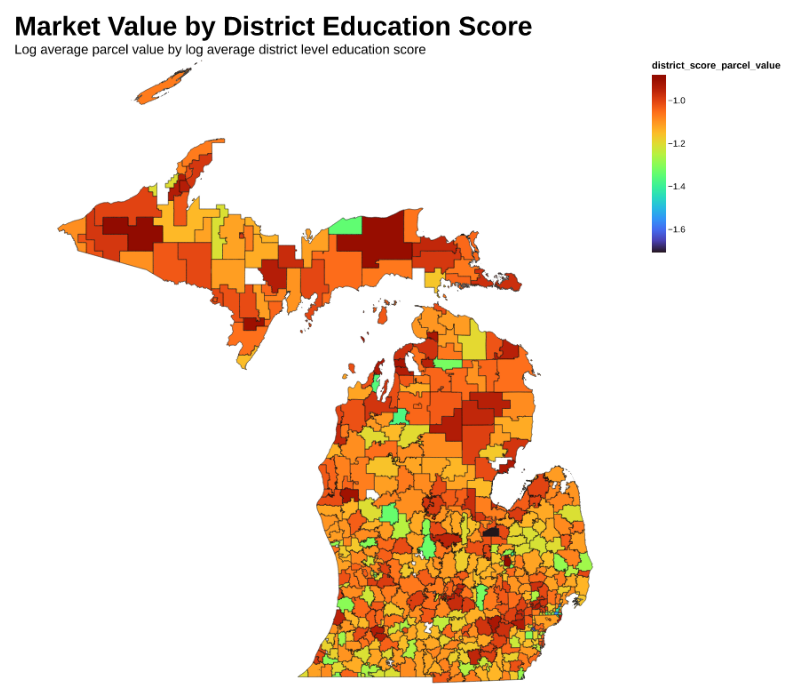

In [124]:
# Base plot - district boarders + color encoded district log average parcel value / log district education score
# The input data is obtained by averaging education scores for entire dataset
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/alt_district_score_per_parcel_value.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    chart = alt.Chart(df_district_joined, title="Parcel Total Valuation Per Acre (Log Scale)").mark_geoshape(stroke='black', strokeWidth=0.5).encode(
        color=alt.Color('district_score_parcel_value:Q').scale(scheme="turbo")
    ).transform_lookup(
        lookup='district_code',
        from_=alt.LookupData(df_parcel_district, 'district_code_dist', ['total_value_calculated', 'size_parcel','total_value_parcel_unit', 'distance'])
    ).transform_calculate(
        district_score_parcel_value="log(datum.total_value_calculated) / datum.log_correct_education_score"
    ).project(
    type='mercator'
    ).properties(
        width=700,
        height=700
    ).properties(
        title=alt.TitleParams(
        text="Market Value by District Education Score", align='left',
        subtitle=['Log average parcel value by log average district level education score'],anchor='start',
        fontSize=30,
        font='sans-serif',
        color='black',
        subtitleFontSize=15, 
        subtitleColor='black', 
    ))

    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()

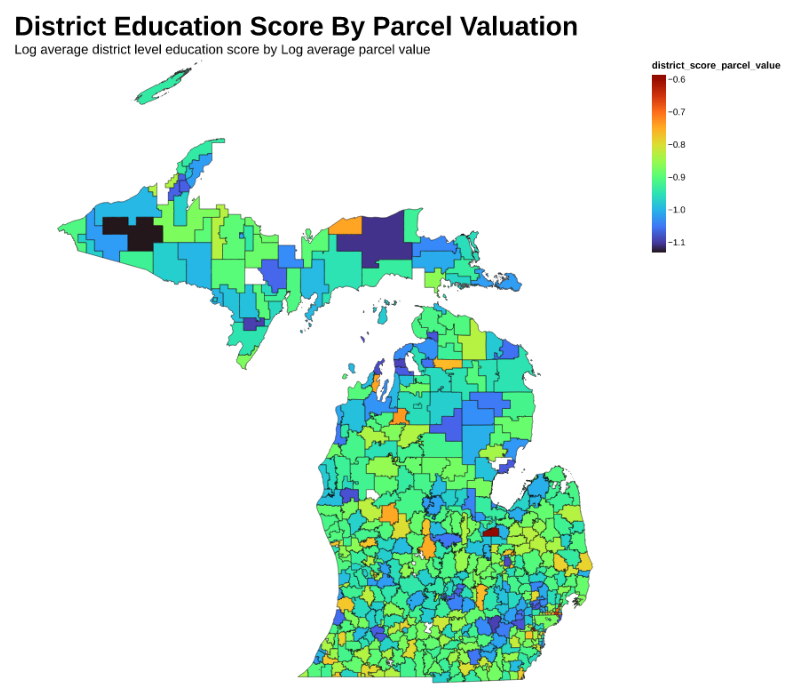

In [17]:
# Base plot - district boarders + color encoded log district education score / district log average parcel value
# The input data is obtained by averaging education scores for entire dataset
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/alt_parcel_value_district_score.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    chart = alt.Chart(df_district_joined, title="Parcel Total Valuation Per Acre (Log Scale)").mark_geoshape(stroke='black', strokeWidth=0.5).encode(
        color=alt.Color('district_score_parcel_value:Q').scale(scheme="turbo")
    ).transform_lookup(
        lookup='district_code',
        from_=alt.LookupData(df_parcel_district, 'district_code_dist', ['total_value_calculated', 'size_parcel','total_value_parcel_unit', 'distance'])
    ).transform_calculate(
        district_score_parcel_value="datum.log_correct_education_score / log(datum.total_value_calculated)"
    ).project(
    type='mercator'
    ).properties(
        width=700,
        height=700
    ).properties(
        title=alt.TitleParams(
        text="District Education Score By Parcel Valuation", align='left',
        subtitle=['Log average district level education score by Log average parcel value'],anchor='start',
        fontSize=30,
        font='sans-serif',
        color='black',
        subtitleFontSize=15, 
        subtitleColor='black', 
    ))

    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()

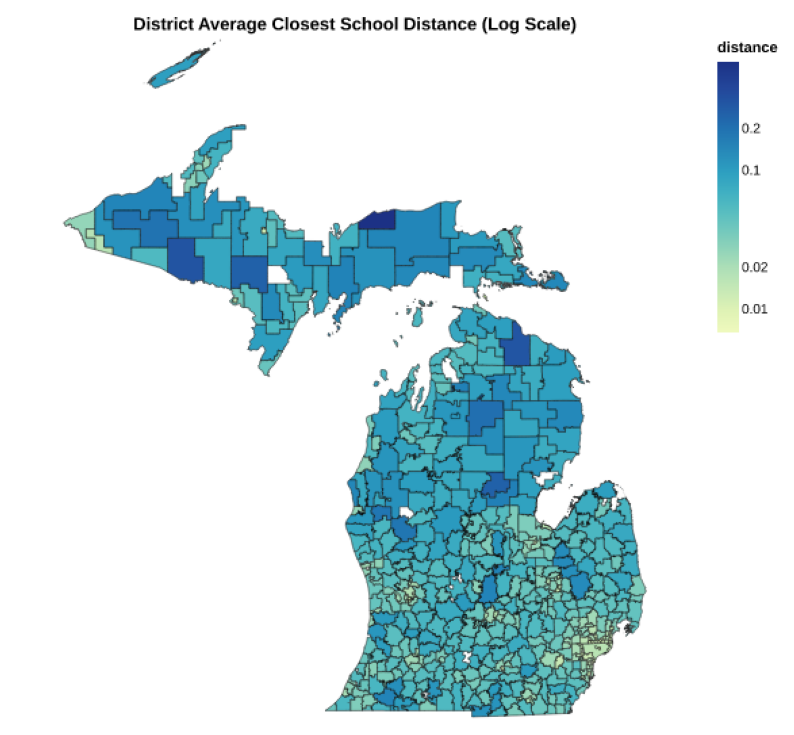

In [42]:
# Base plot - district boarders + district average closes school distance + logged color scale
# The input data is obtained by averaging education scores for entire dataset
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/alt_district_closest_school_distance.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    chart = alt.Chart(df_district_joined, title="District Average Closest School Distance (Log Scale)").mark_geoshape(stroke='black', strokeWidth=0.5).encode(
        color=alt.Color('distance:Q', scale=alt.Scale(type='log'))
    ).transform_lookup(
        lookup='district_code',
        from_=alt.LookupData(df_parcel_district, 'district_code_dist', ['total_value_calculated', 'size_parcel','total_value_parcel_unit', 'distance'])
    ).project(
    type='mercator'
    ).properties(
        width=500,
        height=500
    )

    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()

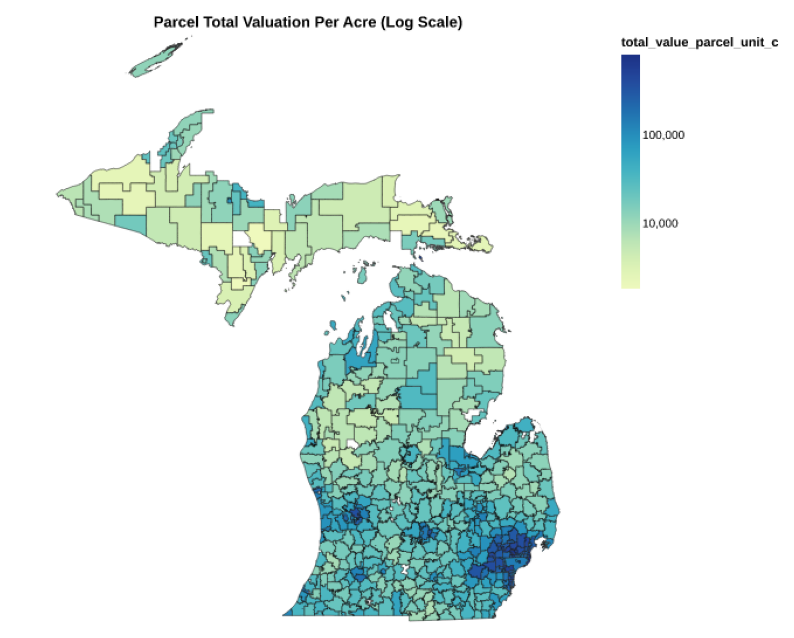

In [40]:
# Base plot - district boarders + district average parcel value / district average parcel size + logged color scale 
# The input data is obtained by averaging education scores for entire dataset
# Implements caching, saves/reads plot from png file

chart_name = "resources/charts/alt_parcel_total_value_per_acre.png"

if regenerate_charts == False and os.path.exists(chart_name):
    render_plot(chart_name).show()
else:
    chart = alt.Chart(df_district_joined, title="Parcel Total Valuation Per Acre (Log Scale)").mark_geoshape(stroke='black', strokeWidth=0.5).encode(
        color=alt.Color('total_value_parcel_unit_c:Q', scale=alt.Scale(type='log'))
    ).transform_lookup(
        lookup='district_code',
        from_=alt.LookupData(df_parcel_district, 'district_code_dist', ['total_value_calculated', 'size_parcel','total_value_parcel_unit', 'distance'])
    ).transform_calculate(
        total_value_parcel_unit_c="datum.total_value_calculated / datum.size_parcel"
    ).project(
    type='mercator'
    ).properties(
        width=500,
        height=500
    )

    chart.save(chart_name, inline=True)
    render_plot(chart_name).show()